# Loading `gwent` SNR Outputs to Generate Comparison Waterfall Plots

Here we present a tutorial on how to use `gwent` output from `Get_SNR_Matrix` to simultaneously plot Mass vs. Redshift SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an coalescing Binary Black Holes.

First, we import the necessary packages.

In [100]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.constants import golden_ratio

import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo

import os,sys
current_directory = os.getcwd()
load_directory = current_directory + '/saved_SNRs/'
v1_directory = load_directory + 'v1/'
v2_directory = load_directory + 'v2/'

current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
save_directory = top_directory + '/Figures/'

Setting matplotlib preferences

In [101]:
print(mpl.rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

/Users/andrewkaiser/anaconda3/envs/gwent-dev/lib/python3.7/_collections_abc.py:705: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  return '{0.__class__.__name__}({0._mapping!r})'.format(self)


In [102]:
def get_fig_size(width=7,scale=2.0):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.dpi'] = 300
#mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 1.3
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8

In [103]:
version = 'v2'

## Loading SNR Data Files

### LISA Only Params

* 'L' - Detector Armlength
* 'A_acc' - Detector Acceleration Noise
* 'A_IFO' - Detector Optical Metrology Noise
* 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
* 'f_acc_break_high' - The High Acceleration Noise Break Frequency
* 'f_IFO_break' - The Optical Metrology Noise Break Frequency

### Global Detector Params

* 'T_obs' - Observation Time Length

In [104]:
def load_stuff(detector_name,var_x,var_y,version):
    if version == 'v1':
        directory = v1_directory
    elif version == 'v2':
        directory = v2_directory
    else:
        raise ValueError('STAHP')
    SNR_filename = detector_name + '_' + var_x + '_vs_' + var_y + '_SNR_' + version + '.txt'
    SNR = np.loadtxt(directory+SNR_filename)
    if var_x == 'N_p' or var_y == 'N_p':
        Sample_filename_1 = detector_name + '_' + var_x + '_vs_' + var_y + '_samples_' + var_x + '_' + version + '.txt'
        Samples_1 = np.loadtxt(directory+Sample_filename_1)
        Sample_filename_2 = detector_name + '_' + var_x + '_vs_' + var_y + '_samples_' + var_y + '_' + version + '.txt'
        Samples_2 = np.loadtxt(directory+Sample_filename_2)
        return [Samples_1,Samples_2,SNR]
    else:
        Sample_filename = detector_name + '_' + var_x + '_vs_' + var_y + '_samples_' + version + '.txt'
        Samples = np.loadtxt(directory+Sample_filename)
        return [Samples,SNR]

In [105]:
def Plot_SNR(fig,ax,var_x,sample_x,var_y,sample_y,SNRMatrix,
             display=True,dl_axis=False,smooth_contours=False,
             display_cbar=False,x_axis_label=True,y_axis_label=True,
             logLevels_min=-1.0,logLevels_max=0.0,hspace=0.15,wspace=0.1,
             y_label_loc = -.25):
    """Plots the SNR contours from calcSNR

    Parameters
    ----------
    var_x : str
        x-axis variable
    sample_x : array
        samples at which SNRMatrix was calculated corresponding to the x-axis variable
    var_y : str
        y-axis variable
    sample_y : array
        samples at which SNRMatrix was calculated corresponding to the y-axis variable
    SNRMatrix : array-like
        the matrix at which the SNR was calculated corresponding to the particular x and y-axis variable choices

    display : bool, optional
        Option to turn off display if saving multiple plots to a file
    dl_axis : bool, optional
        Option to turn on the right hand side labels of luminosity distance
    smooth_contours : bool, optional
        Option to interpolate contours to a finer mesh size to appear smooth instead of tiered contours

    """
    textcolor = 'k'
    cf_alpha = 1.0
    
    
    colormap = 'viridis'
    logSNR = np.log10(SNRMatrix)
    if logLevels_min == -1.0:
        logLevels_min = np.log10(np.array([5]))
    if logLevels_max == 0.0:
        logLevels_max = np.ceil(np.amax(logSNR))
    if logLevels_max < logLevels_min:
        raise ValueError('All SNRs are lower than 5.')
    print_logLevels = np.append(logLevels_min,np.arange(1,logLevels_max+1))
    if smooth_contours:
        logLevels = np.linspace(logLevels_min,logLevels_max,100)[:,0]
    else:
        logLevels = print_logLevels
        
    ylabel_min = min(sample_y)
    ylabel_max = max(sample_y)
    xlabel_min = min(sample_x)
    xlabel_max = max(sample_x)

    #Set whether log or linearly spaced axes
    if var_x in ['M','z','L','A_acc','A_IFO']:
        xaxis_type = 'log'
    else:
        xaxis_type = 'lin'

    if var_y in ['M','z','L','A_acc','A_IFO']:
        yaxis_type = 'log'
    else:
        yaxis_type = 'lin'

    #Set axis scales based on what data sampling we used 
    if yaxis_type == 'lin' and xaxis_type == 'log':
        CS1 = ax.contourf(np.log10(sample_x),sample_y,logSNR,logLevels,cmap = colormap,alpha=cf_alpha)
        ax.contour(np.log10(sample_x),sample_y,logSNR,print_logLevels,colors = 'k',alpha=1.0)
        ax.set_xlim(np.log10(xlabel_min),np.log10(xlabel_max))
        ax.set_ylim(ylabel_min,ylabel_max)
        x_labels = np.logspace(np.log10(xlabel_min),np.log10(xlabel_max),np.log10(xlabel_max)-np.log10(xlabel_min)+1)
        y_labels = np.linspace(ylabel_min,ylabel_max,ylabel_max-ylabel_min+1)
        ax.set_yticks(y_labels)
        ax.set_xticks(np.log10(x_labels))
    elif yaxis_type == 'log' and xaxis_type == 'lin':
        CS1 = ax.contourf(sample_x,np.log10(sample_y),logSNR,logLevels,cmap = colormap,alpha=cf_alpha)
        ax.contour(sample_x,np.log10(sample_y),logSNR,print_logLevels,colors = 'k',alpha=1.0)
        ax.set_xlim(xlabel_min,xlabel_max)
        ax.set_ylim(np.log10(ylabel_min),np.log10(ylabel_max))
        x_labels = np.linspace(xlabel_min,xlabel_max,xlabel_max-xlabel_min+1)
        y_labels = np.logspace(np.log10(ylabel_min),np.log10(ylabel_max),np.log10(ylabel_max)-np.log10(ylabel_min)+1)
        ax.set_xticks(x_labels)
        ax.set_yticks(np.log10(y_labels))
    elif yaxis_type == 'lin' and xaxis_type == 'lin':
        CS1 = ax.contourf(sample_x,sample_y,logSNR,logLevels,cmap = colormap,alpha=cf_alpha)
        ax.contour(sample_x,sample_y,logSNR,print_logLevels,colors = 'k',alpha=1.0)
        ax.set_xlim(xlabel_min,xlabel_max)
        ax.set_ylim(ylabel_min,ylabel_max)
        x_labels = np.linspace(xlabel_min,xlabel_max,xlabel_max-xlabel_min+1)
        y_labels = np.linspace(ylabel_min,ylabel_max,ylabel_max-ylabel_min+1)
        ax.set_xticks(x_labels)
        ax.set_yticks(y_labels)
    else:
        CS1 = ax.contourf(np.log10(sample_x),np.log10(sample_y),logSNR,logLevels,cmap=colormap,alpha=cf_alpha)
        ax.contour(np.log10(sample_x),np.log10(sample_y),logSNR,print_logLevels,colors = 'k',alpha=1.0)
        ax.set_xlim(np.log10(xlabel_min),np.log10(xlabel_max))
        ax.set_ylim(np.log10(ylabel_min),np.log10(ylabel_max))
        x_labels = np.logspace(np.log10(xlabel_min),np.log10(xlabel_max),np.log10(xlabel_max)-np.log10(xlabel_min)+1)
        y_labels = np.logspace(np.log10(ylabel_min),np.log10(ylabel_max),np.log10(ylabel_max)-np.log10(ylabel_min)+1)
        ax.set_yticks(np.log10(y_labels))
        ax.set_xticks(np.log10(x_labels))
                
    #Set axes labels and whether log or linearly spaced
    if var_x == 'M':
        ax.set_xlabel(r'$M_{\rm tot}$ $[\mathrm{M_{\odot}}]$')
        ax.set_xticklabels([r'$10^{%i}$' %x if int(x) > 1 else r'$%i$' %(10**x) for x in np.log10(x_labels)],
                            rotation=70,y=0.02)
    elif var_x == 'q':
        x_labels = x_labels[::2]
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$\mathrm{Mass~Ratio}$')
        ax.set_xticklabels([r'$%i$' %int(x) for x in x_labels])
    elif var_x == 'z':
        ax.set_xlabel(r'$\mathrm{Redshift}$',fontsize = labelsize)
        ax.set_xticklabels([x if int(x) < 1 else int(x) for x in x_labels])
    elif var_x in ['chi1','chi2']:
        x_labels = np.arange(round(xlabel_min*10),round(xlabel_max*10)+1,1)/10
        x_labels = x_labels[::2]
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$\mathrm{Spin}$')
        ax.set_xticklabels([r'$%.1f$' %x for x in x_labels])
    elif var_x == 'L':
        ax.axvline(x=np.log10(2.5*u.Gm.to('m')),linestyle='--',color='k',label='Proposed Value')
        ax.set_xlabel(r'${\rm Armlength}$ $[\mathrm{m}]$')
        ax.set_xticklabels([r'$10^{%i}$' %x if int(x) > 1 else r'$%i$' %(10**x) for x in np.log10(x_labels)])
         
    elif var_x == 'A_acc':
        ax.axvline(x=np.log10(3e-15),linestyle='--',color='k',label='Proposed Value')
        ax.set_xlabel(r'\centering Acceleration Noise \newline Amplitude $[\mathrm{m~s^{-2}}]$')
        ax.set_xticklabels([r'$10^{%.0f}$' %x for x in np.log10(x_labels)],fontsize = axissize)
    elif var_x == 'A_IFO':
        ax.axvline(x=np.log10(10e-12),linestyle='--',color='k',label='Proposed Value')
        ax.set_xlabel(r'\centering Optical Metrology \newline Noise Amplitude [m]')
        ax.set_xticklabels([r'$10^{%.0f}$' %x for x in np.log10(x_labels)])
    elif var_x == 'f_acc_break_low':
        ax.axvline(x=.4*u.mHz.to('Hz'),linestyle='--',color='k',label='Proposed Value')
        scale = 10**round(np.log10(xlabel_min))
        x_labels = np.arange(round(xlabel_min/scale),round(xlabel_max/scale)+1,1)*scale
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$f_{\mathrm{acc,low}}$ $[\mathrm{mHz}]$')
        ax.set_xticklabels([r'$%.1f$' %x for x in x_labels*1e3])
    elif var_x == 'f_acc_break_high':
        ax.axvline(x=8.*u.mHz.to('Hz'),linestyle='--',color='k',label='Proposed Value')
        scale = 10**round(np.log10(xlabel_min))
        x_labels = np.arange(round(xlabel_min/scale),round(xlabel_max/scale)+1,1)*scale
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$f_{\mathrm{acc,high}}$ $[\mathrm{mHz}]$')
        ax.set_xticklabels([r'$%.1f$' %x for x in x_labels*1e3])
    elif var_x == 'f_IFO_break':
        ax.axvline(x=2.*u.mHz.to('Hz'),linestyle='--',color='k',label='Proposed Value')
        scale = 10**round(np.log10(xlabel_min))
        x_labels = np.arange(round(xlabel_min/scale),round(xlabel_max/scale)+1,1)*scale
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$f_{\mathrm{IFO,break}}$ $[\mathrm{mHz}]$')
        ax.set_xticklabels([r'$%.1f$' %x for x in x_labels*1e3])
    elif var_x == 'N_p':
        sample_range = max(x_labels)-min(x_labels)
        sample_rate = max(2,int(sample_range/10))
        x_labels = x_labels[::sample_rate]
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$\mathrm{Number~of~Pulsars}$')
        ax.set_xticklabels([r'$%i$' %int(x) for x in x_labels])
    elif var_x == 'cadence': 
        x_labels = np.arange(round(xlabel_min),round(xlabel_max)+1,5)
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$\mathrm{Observation~Cadence}$ $[\mathrm{yr}^{-1}]$')
        ax.set_xticklabels([r'$%i$' %int(x) for x in x_labels])
    elif var_x == 'sigma':
        scale = 10**round(np.log10(xlabel_min))
        x_labels = np.arange(round(xlabel_min/scale),round(xlabel_max/scale)+1,1)*scale
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'$\mathrm{Pulsar~Timing~RMS}$ $[\mathrm{ns}]$')
        ax.set_xticklabels([r'$%.0f$' %x for x in x_labels*1e9])
    elif var_x == 'T_obs':
        x_labels = x_labels[::2]
        ax.set_xticks(x_labels)
        ax.set_xlabel(r'${\rm T_{obs}}$ $[\mathrm{yr}]$')
        ax.set_xticklabels([r'$%i$' %int(x) for x in x_labels])
    if var_y == 'M':
        ax.set_ylabel(r'$M_{\rm tot}$ $[\mathrm{M_{\odot}}]$')
        ax.set_yticklabels([r'$10^{%i}$' %y if int(y) > 1 else r'$%i$' %(10**y) for y in np.log10(y_labels)],
                           rotation=-45)
    elif var_y == 'q':
        y_labels = y_labels[::2]
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$\mathrm{Mass~Ratio}$')
        ax.set_yticklabels([r'$%i$' %int(y) for y in y_labels])
    elif var_y == 'z':
        ax.set_ylabel(r'$\mathrm{Redshift}$')
        ax.set_yticklabels([y if int(y) < 1 else int(y) for y in y_labels])
    elif var_y in ['chi1','chi2']:
        y_labels = np.arange(round(ylabel_min*10),round(ylabel_max*10)+1,1)/10
        y_labels = y_labels[::2]
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$\mathrm{Spin}$')
        ax.set_yticklabels([r'$%.1f$' %y for y in y_labels])
    elif var_y == 'L':
        ax.axhline(y=np.log10(2.5*u.Gm.to('m')),linestyle='--',color='k',label='Proposed Value')
        ax.set_ylabel(r'${\rm Armlength}$ $[\mathrm{m}]$')
        ax.set_yticklabels([r'$10^{%i}$' %y if int(y) > 1 else r'$%i$' %(10**y) for y in np.log10(y_labels)])
    elif var_y == 'A_acc':
        ax.axhline(y=np.log10(3e-15),linestyle='--',color='k',label='Proposed Value')
        ax.set_ylabel(r'\centering Acceleration Noise \newline Amplitude $[\mathrm{m~s^{-2}}]$')
        ax.set_yticklabels([r'$10^{%.0f}$' %y for y in np.log10(y_labels)])
    elif var_y == 'A_IFO':
        ax.axhline(y=np.log10(10e-12),linestyle='--',color='k', label='Proposed Value')
        ax.set_ylabel(r'\centering Optical Metrology \newline Noise Amplitude [m]')
        ax.set_yticklabels([r'$10^{%.0f}$' %y for y in np.log10(y_labels)])
    elif var_y == 'f_acc_break_low':
        ax.axhline(y=.4*u.mHz.to('Hz'),linestyle='--',color='k',label='Proposed Value')
        scale = 10**round(np.log10(ylabel_min))
        y_labels = np.arange(round(ylabel_min/scale),round(ylabel_max/scale)+1,1)*scale
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$f_{\mathrm{acc,low}} [\mathrm{mHz}]$')
        ax.set_yticklabels([r'$%.1f$' %y for y in y_labels*1e3])
    elif var_y == 'f_acc_break_high':
        ax.axhline(y=8.*u.mHz.to('Hz'),linestyle='--',color='k',label='Proposed Value')
        scale = 10**round(np.log10(ylabel_min))
        y_labels = np.arange(round(ylabel_min/scale),round(ylabel_max/scale)+1,1)*scale
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$f_{\mathrm{acc,high}} [\mathrm{mHz}]$')
        ax.set_yticklabels([r'$%.1f$' %y for y in y_labels*1e3])
    elif var_y == 'f_IFO_break':
        ax.axhline(y=2.*u.mHz.to('Hz'),linestyle='--',color='k',label='Proposed Value')
        scale = 10**round(np.log10(ylabel_min))
        y_labels = np.arange(round(ylabel_min/scale),round(ylabel_max/scale)+1,1)*scale
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$f_{\mathrm{IFO,break}} [\mathrm{mHz}]$')
        ax.set_yticklabels([r'$%.1f$' %y for y in y_labels*1e3])
    elif var_y == 'N_p':
        sample_range = max(y_labels)-min(y_labels)
        sample_rate = max(2,int(sample_range/10))
        y_labels = y_labels[::sample_rate]
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$\mathrm{Number~of~Pulsars}$')
        ax.set_yticklabels([r'$%i$' %int(y) for y in y_labels])
    elif var_y == 'cadence': 
        y_labels = np.arange(round(ylabel_min),round(ylabel_max)+1,5)
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$\mathrm{Observation~Cadence}$ $[\mathrm{yr}^{-1}]$')
        ax.set_yticklabels([r'$%i$' %int(y) for y in y_labels])
    elif var_y == 'sigma':
        scale = 10**round(np.log10(ylabel_min))
        y_labels = np.arange(round(ylabel_min/scale),round(ylabel_max/scale)+1,1)*scale
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'$\mathrm{Pulsar~Timing~RMS}$ $[\mathrm{ns}]$')
        ax.set_yticklabels([r'$%.0f$' %y for y in y_labels*1e9])
    elif var_y == 'T_obs':
        y_labels = y_labels[::2]
        ax.set_yticks(y_labels)
        ax.set_ylabel(r'${\rm T_{obs}}$ $[\mathrm{yr}]$')
        ax.set_yticklabels([r'$%i$' %int(y) for y in y_labels])
        
    if not x_axis_label:
        #ax.get_xaxis().set_visible(False)
        ax.set_xticklabels('')
        ax.set_xlabel('')
    if not y_axis_label:
        #ax.get_yaxis().set_visible(False)
        ax.set_yticklabels('')
        ax.set_ylabel('')
    
    if var_y in ['A_acc','A_IFO']:
        ax.yaxis.set_label_coords(y_label_loc-.1,.5)
    elif var_y in ['chi1','chi2']:
        ax.yaxis.set_label_coords(y_label_loc-.05,.5)
    else:
        ax.yaxis.set_label_coords(y_label_loc,.5)

    if display_cbar:
        #If true, display luminosity distance on right side of plot
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.82, 0.15, 0.025, 0.7])
        if dl_axis:
            #Set other side y-axis for lookback time scalings
            ax2 = ax.twinx()
            #Set axis scales based on what data sampling we used 
            if yaxis_type == 'lin' and xaxis_type == 'log':
                ax2.contour(np.log10(sample_x),sample_y,logSNR,print_logLevels,colors = 'k',alpha=1.0)
            elif yaxis_type == 'log' and xaxis_type == 'lin':
                ax2.contour(sample_x,np.log10(sample_y),logSNR,print_logLevels,colors = 'k',alpha=1.0)
            else:
                ax2.contour(np.log10(sample_x),np.log10(sample_y),logSNR,print_logLevels,colors = 'k',alpha=1.0)

            dists_min = cosmo.luminosity_distance(source.var_dict['z']['min']).to('Gpc')
            dists_min = np.ceil(np.log10(dists_min.value))
            dists_max = cosmo.luminosity_distance(source.var_dict['z']['max']).to('Gpc')
            dists_max = np.ceil(np.log10(dists_max.value))
            dists = np.arange(dists_min,dists_max)
            dists = 10**dists*u.Gpc

            distticks = [z_at_value(cosmo.luminosity_distance,dist) for dist in dists]
            #Set other side y-axis for lookback time scalings
            ax2.set_yticks(np.log10(distticks))
            #ax2.set_yticklabels(['%f' %dist for dist in distticks],fontsize = axissize)
            ax2.set_yticklabels([r'$10^{%i}$' %np.log10(dist) if np.abs(int(np.log10(dist))) > 1 
                                 else '{:g}'.format(dist) for dist in dists.value])
            ax2.set_ylabel(r'$D_{L}$ [Gpc]')
            cbar = fig.colorbar(CS1,ax=(ax,ax2),pad=0.01,ticks=print_logLevels)
        else:
            #Make colorbar
            cbar = fig.colorbar(CS1, cax=cbar_ax,ticks=print_logLevels)
        cbar.set_label(r'$SNR$')
        cbar.ax.set_yticklabels([r'$10^{%i}$' %x if int(x) > 1 else r'$%i$' %(10**x) for x in print_logLevels])

    if display:
        #fig.tight_layout()
        fig.subplots_adjust(hspace=hspace,wspace=wspace)
        plt.show()

## Space Based

#### LISA Proposal 1

SNR values from the ESA L3 proposal run.

Load SNR from file

In [106]:
[lisa_Samples_M_vs_A_acc,lisa_SNR_M_vs_A_acc] = load_stuff('LISA_ESA','M','A_acc',version)
[lisa_Samples_M_vs_L,lisa_SNR_M_vs_L] = load_stuff('LISA_ESA','M','L',version)
[lisa_Samples_M_vs_A_IFO,lisa_SNR_M_vs_A_IFO] = load_stuff('LISA_ESA','M','A_IFO',version)
[lisa_Samples_M_vs_f_acc_break_low,lisa_SNR_M_vs_f_acc_break_low] = load_stuff('LISA_ESA','M','f_acc_break_low',version)
[lisa_Samples_M_vs_f_acc_break_high,lisa_SNR_M_vs_f_acc_break_high] = load_stuff('LISA_ESA','M','f_acc_break_high',version)
[lisa_Samples_M_vs_f_IFO_break,lisa_SNR_M_vs_f_IFO_break] = load_stuff('LISA_ESA','M','f_IFO_break',version)
[lisa_Samples_M_vs_T_obs,lisa_SNR_M_vs_T_obs] = load_stuff('LISA_ESA','M','T_obs',version)
[lisa_Samples_M_vs_z,lisa_SNR_M_vs_z] = load_stuff('LISA_ESA','M','z',version)
[lisa_Samples_M_vs_q,lisa_SNR_M_vs_q] = load_stuff('LISA_ESA','M','q',version)
[lisa_Samples_M_vs_chi1,lisa_SNR_M_vs_chi1] = load_stuff('LISA_ESA','M','chi1',version)
[lisa_Samples_L_vs_q,lisa_SNR_L_vs_q] = load_stuff('LISA_ESA','L','q',version)
[lisa_Samples_L_vs_z,lisa_SNR_L_vs_z] = load_stuff('LISA_ESA','L','z',version)
[lisa_Samples_L_vs_chi1,lisa_SNR_L_vs_chi1] = load_stuff('LISA_ESA','L','chi1',version)

First column is x-axis variable, second is y-axis variable
z and M sample space corresponding to SNR height

#### All Space Based Plots

M vs source params

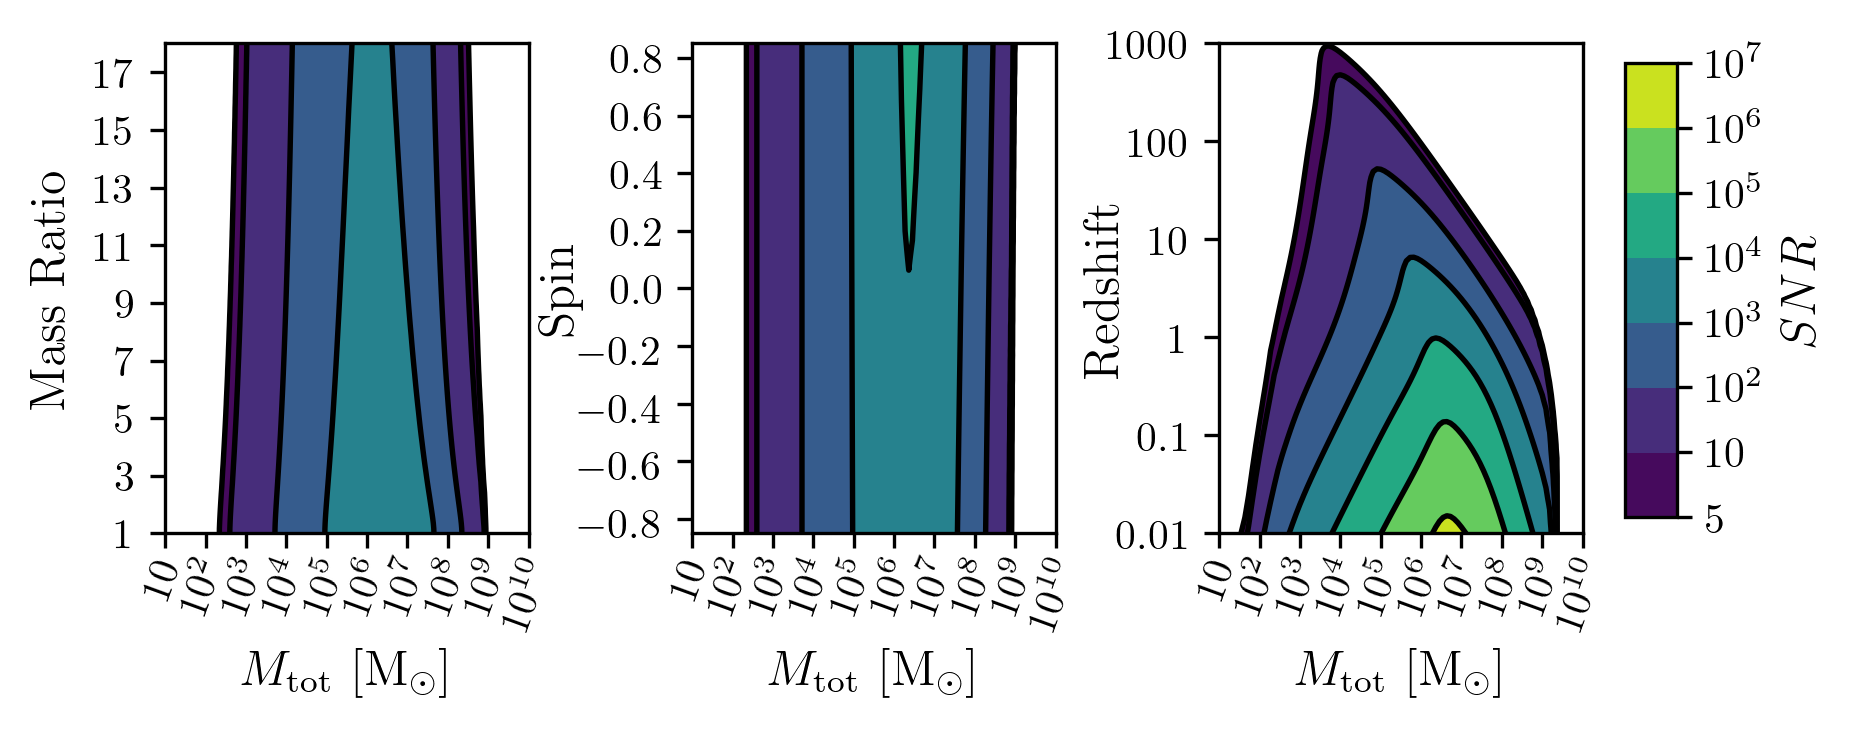

In [107]:
#########################
#Make the Contour Plots
figsize = get_fig_size()
fig, axes = plt.subplots(1,3,figsize=figsize)
samples = [lisa_Samples_M_vs_q,lisa_Samples_M_vs_chi1,lisa_Samples_M_vs_z]
SNRs = [lisa_SNR_M_vs_q,lisa_SNR_M_vs_chi1,lisa_SNR_M_vs_z]
var_ys = ['q','chi1','z']
loglevelMin=-1.0
loglevelMax=7.0
hspace = .1
wspace = .45

ii = 0
for i in range(len(axes)):
    if ii == (len(axes))-1:
        Plot_SNR(fig,axes[i],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
             SNRs[ii],display=True,display_cbar=True,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace)
    else:
        Plot_SNR(fig,axes[i],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                 SNRs[ii],display=False,display_cbar=False,
                 logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                 hspace=hspace,wspace=wspace)
    ii += 1
fig.savefig(save_directory+'SNR_LISA_M_vs_source_params.pdf',bbox_inches='tight')

L vs params

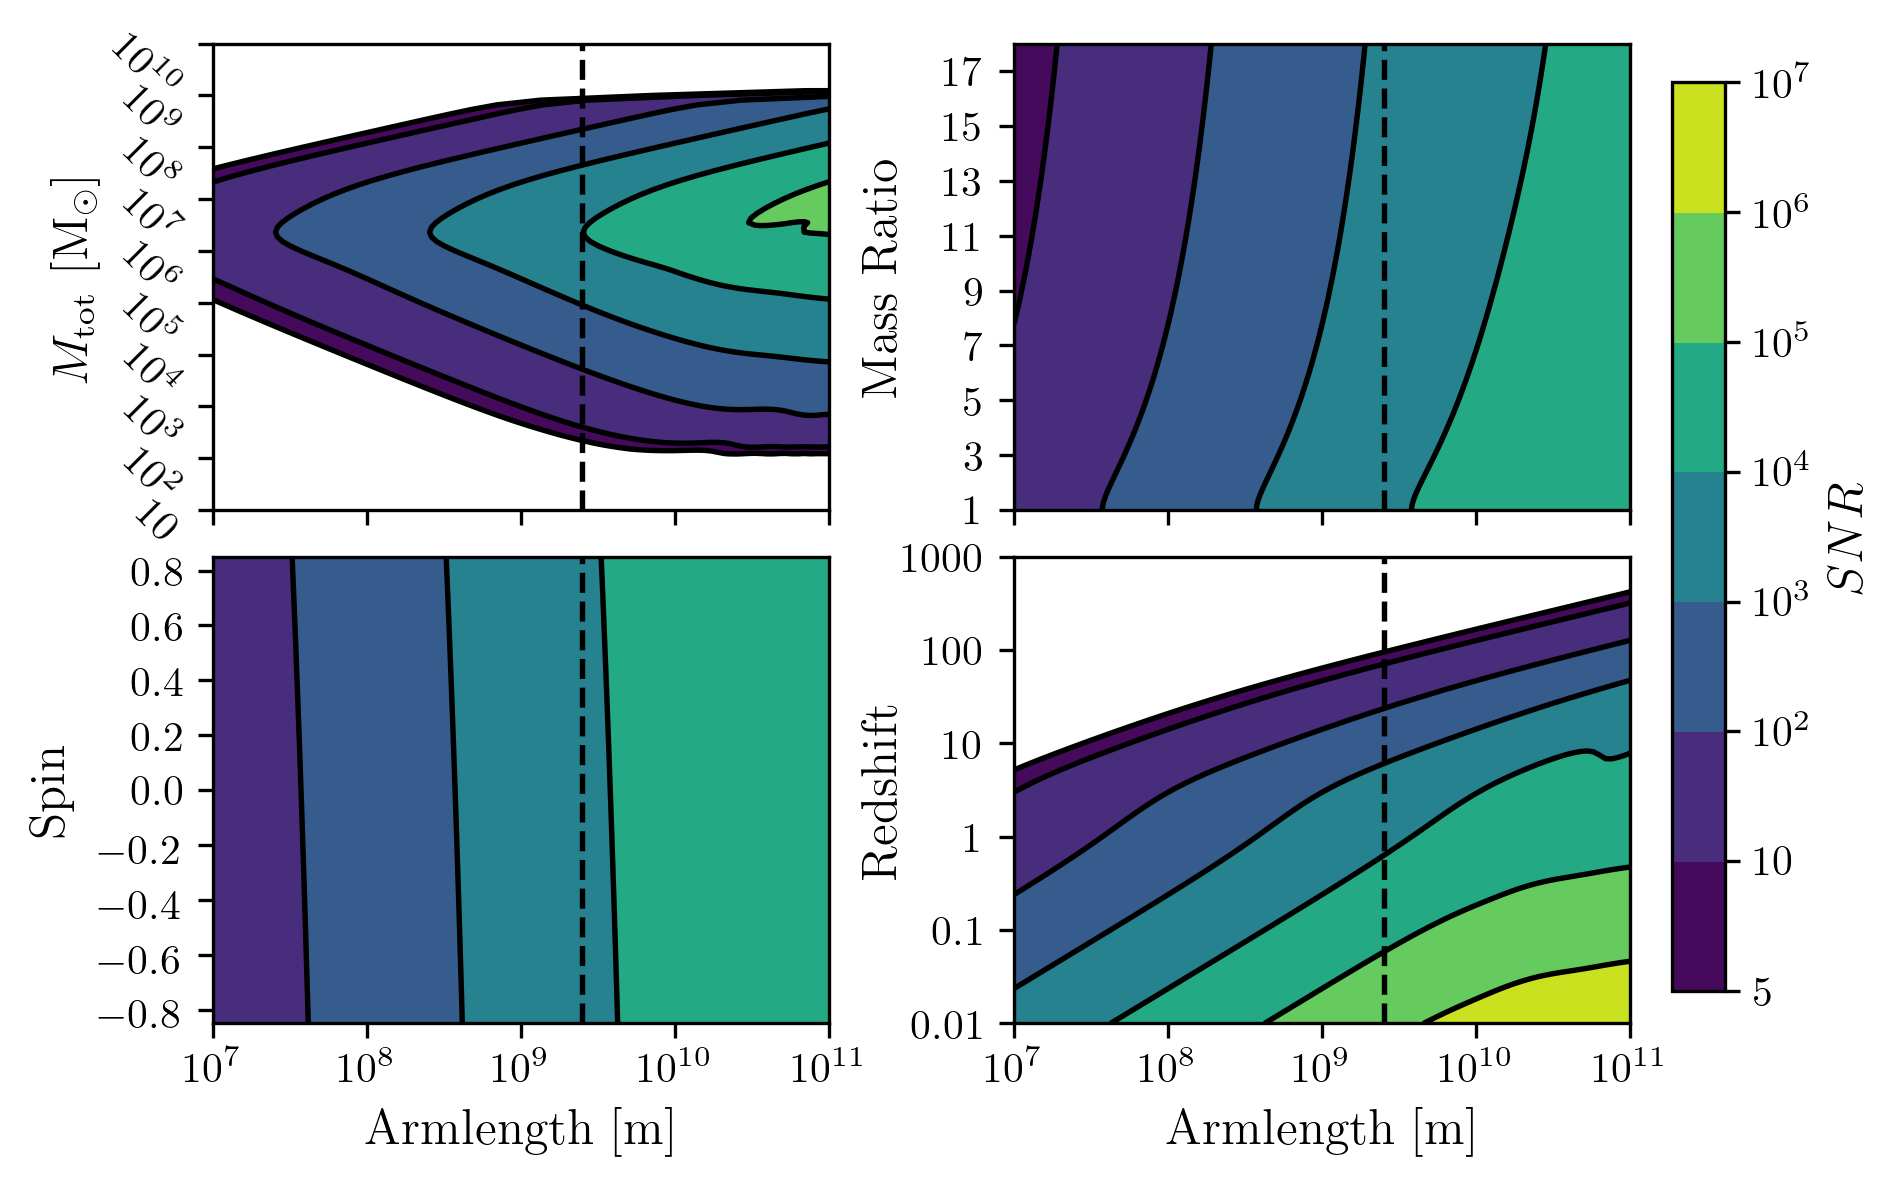

In [108]:
#########################
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [lisa_Samples_M_vs_L,lisa_Samples_L_vs_q,lisa_Samples_L_vs_chi1,lisa_Samples_L_vs_z]
SNRs = [lisa_SNR_M_vs_L,lisa_SNR_L_vs_q,lisa_SNR_L_vs_chi1,lisa_SNR_L_vs_z]
var_ys = ['M','q','chi1','z']
loglevelMin=-1.0
loglevelMax=7.0
hspace = .1
wspace = .3
y_label_loc = -.175

ii = 0
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'L',samples[ii][:,1],var_ys[ii],samples[ii][:,0],
                 SNRs[ii].T,display=False,display_cbar=False,x_axis_label=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        elif ii == (np.shape(axes)[0]*np.shape(axes)[1])-1:
            Plot_SNR(fig,axes[i,j],'L',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=True,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'L',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'L',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        ii += 1
fig.savefig(save_directory+'SNR_LISA_L_vs_params.pdf',bbox_inches='tight')

M vs instrument params

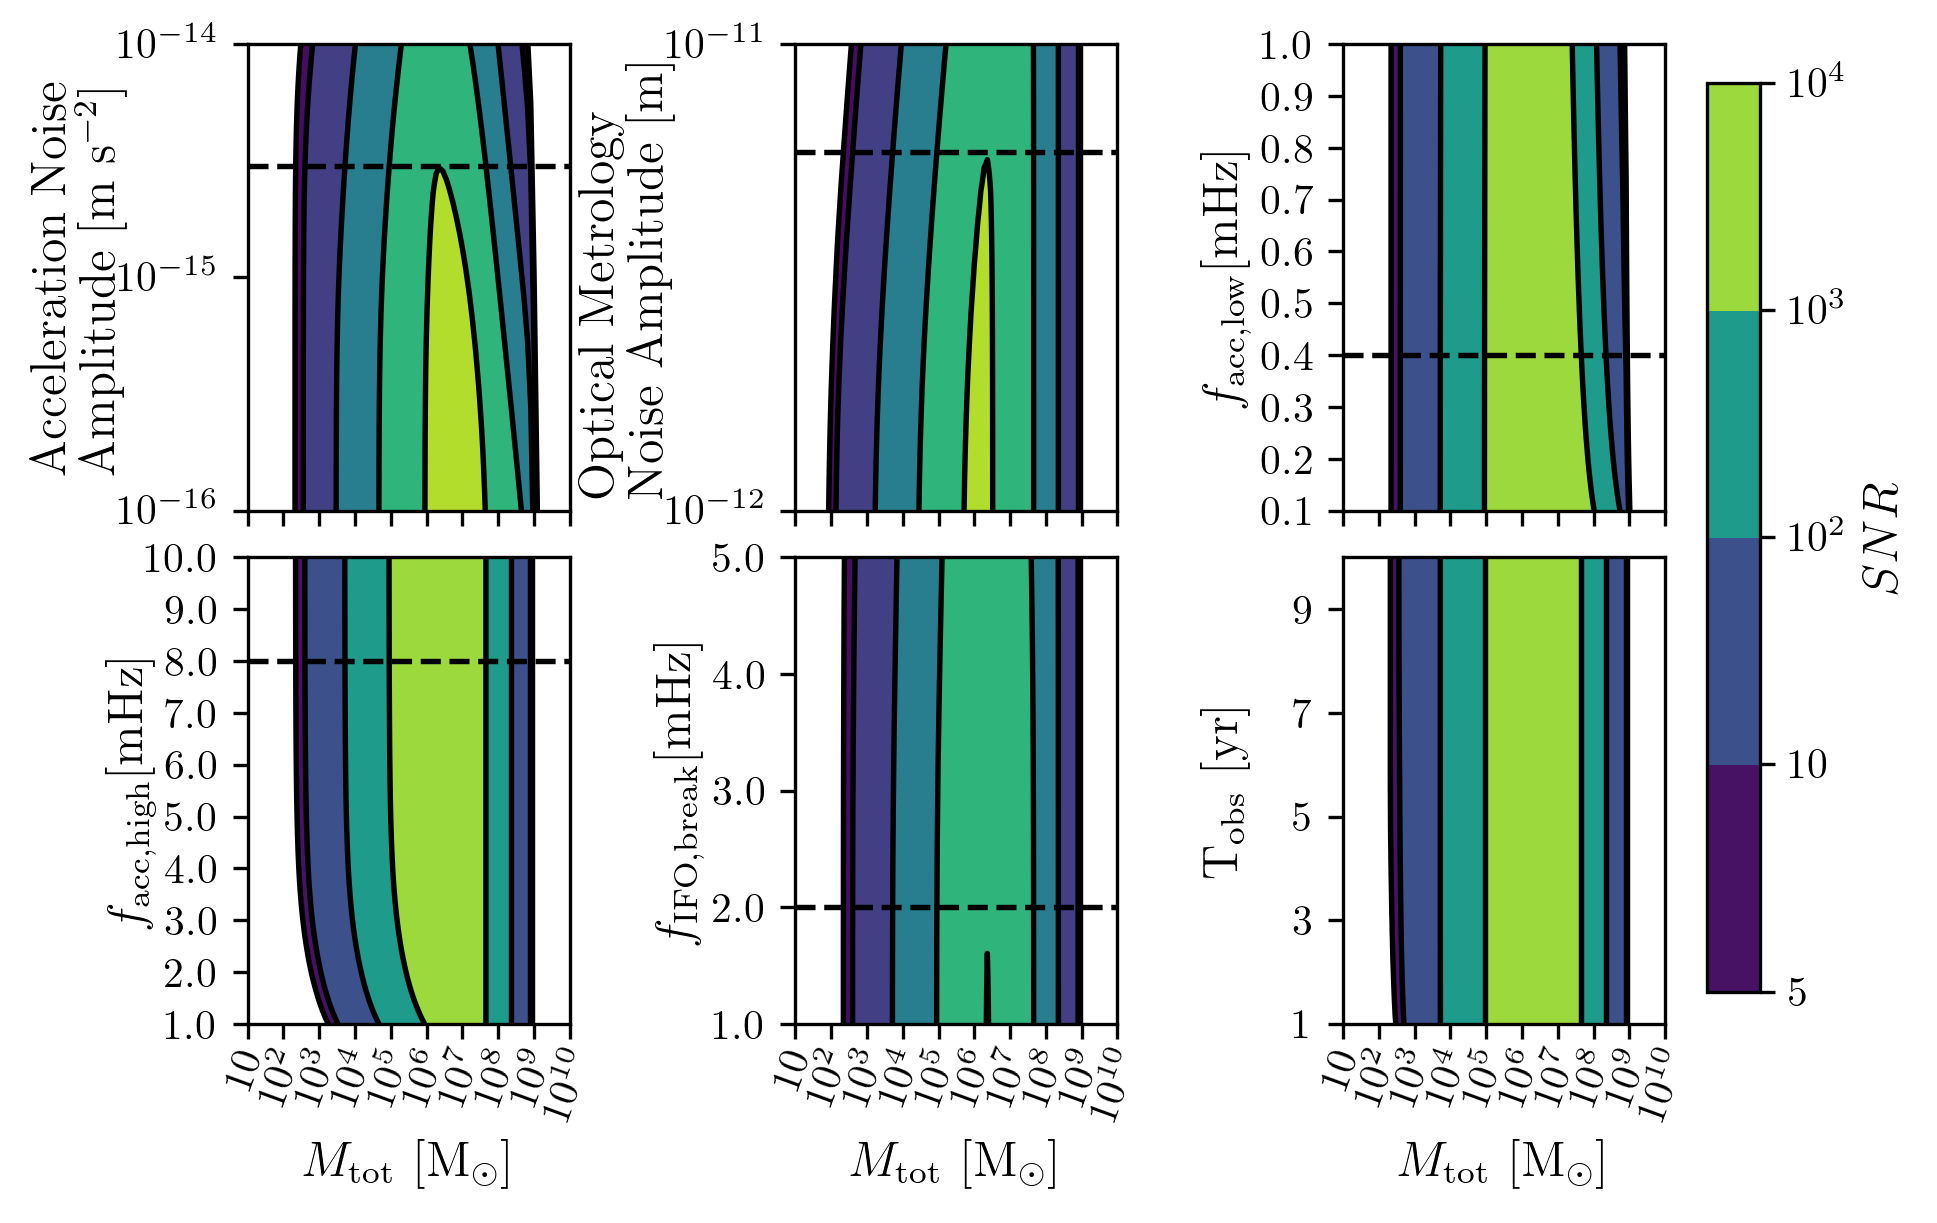

In [109]:
#########################
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,3,figsize=figsize)
samples = [lisa_Samples_M_vs_A_acc,
           lisa_Samples_M_vs_A_IFO,lisa_Samples_M_vs_f_acc_break_low,
           lisa_Samples_M_vs_f_acc_break_high,lisa_Samples_M_vs_f_IFO_break,
           lisa_Samples_M_vs_T_obs]
SNRs = [lisa_SNR_M_vs_A_acc,
        lisa_SNR_M_vs_A_IFO,lisa_SNR_M_vs_f_acc_break_low,
        lisa_SNR_M_vs_f_acc_break_high,lisa_SNR_M_vs_f_IFO_break,
        lisa_SNR_M_vs_T_obs]
var_ys = ['A_acc','A_IFO','f_acc_break_low','f_acc_break_high','f_IFO_break','T_obs']
loglevelMin=-1.0
loglevelMax=0.0
hspace = .1
wspace = .7
y_label_loc = -.275

#fig.delaxes(axes[np.shape(axes)[0]-1,np.shape(axes)[1]-1])

ii = 0
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if ii == (np.shape(axes)[0]*np.shape(axes)[1])-1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=True,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        elif ii in [(np.shape(axes)[0]*np.shape(axes)[1])-2,(np.shape(axes)[0]*np.shape(axes)[1])-3]:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        ii += 1
        
fig.savefig(save_directory+'SNR_LISA_M_vs_inst_params.pdf',bbox_inches='tight')

## Ground Based

#### Einstein Telescope

SNR values from the Einstein Telescope proposal run.

In [110]:
[et_Samples_M_vs_chi1,et_SNR_M_vs_chi1] = load_stuff('ET','M','chi1',version)
[et_Samples_M_vs_q,et_SNR_M_vs_q] = load_stuff('ET','M','q',version)
[et_Samples_M_vs_z,et_SNR_M_vs_z] = load_stuff('ET','M','z',version)

#### aLIGO

SNR values from the Advanced LIGO run.

In [111]:
[aLIGO_Samples_M_vs_chi1,aLIGO_SNR_M_vs_chi1] = load_stuff('aLIGO','M','chi1',version)
[aLIGO_Samples_M_vs_q,aLIGO_SNR_M_vs_q] = load_stuff('aLIGO','M','q',version)
[aLIGO_Samples_M_vs_z,aLIGO_SNR_M_vs_z] = load_stuff('aLIGO','M','z',version)

#### All Ground Based Plots

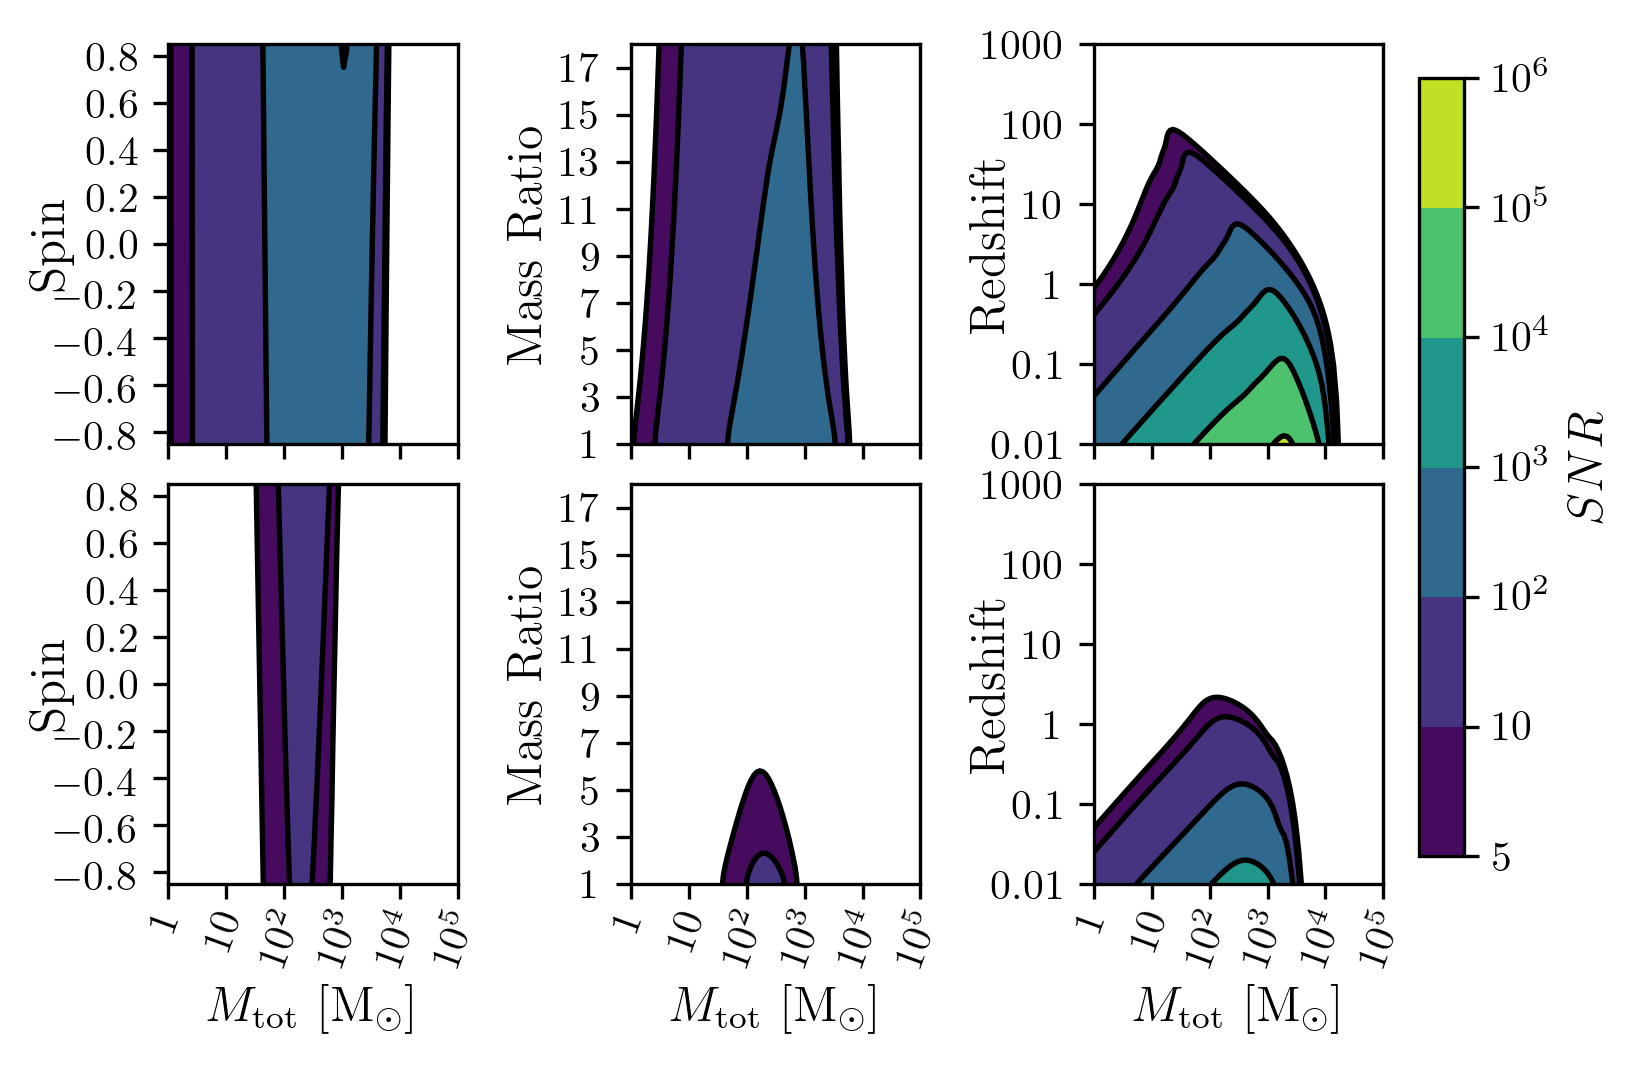

In [112]:
#########################
#Make the Contour Plots
figsize = get_fig_size(width=6.0,scale=1.0)
fig, axes = plt.subplots(2,3,figsize=figsize)
samples = [et_Samples_M_vs_chi1,et_Samples_M_vs_q,et_Samples_M_vs_z,
           aLIGO_Samples_M_vs_chi1,aLIGO_Samples_M_vs_q,aLIGO_Samples_M_vs_z]
SNRs = [et_SNR_M_vs_chi1,et_SNR_M_vs_q,et_SNR_M_vs_z,
        aLIGO_SNR_M_vs_chi1,aLIGO_SNR_M_vs_q,aLIGO_SNR_M_vs_z]
var_ys = ['chi1','q','z']
loglevelMin=-1.0
loglevelMax=6.0
hspace = .1
wspace = .6
y_label_loc = -.275

ii = 0
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        var_y=var_ys[j]
        if ii%3 == 0:
            if ii == (np.shape(axes)[0]*np.shape(axes)[1])-3:
                Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_y,samples[ii][:,1],
                        SNRs[ii],display=False,display_cbar=False,
                        logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                        hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
            else:
                Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_y,samples[ii][:,1],
                         SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                         logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                         hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        elif ii == (np.shape(axes)[0]*np.shape(axes)[1])-1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_y,samples[ii][:,1],
                     SNRs[ii],display=True,display_cbar=True,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        elif ii == (np.shape(axes)[0]*np.shape(axes)[1])-2:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_y,samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_y,samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        ii += 1
fig.savefig(save_directory+'SNR_Ground_M_vs_params.pdf',bbox_inches='tight')

## PTAs

### PTA Only Params

* 'N_p' - Number of Pulsars
* 'sigma' - Root-Mean-Squared Timing Error
* 'cadence' - Observation Cadence

### Global Detector Params

* 'T_obs' - Observation Time Length

#### NANOGrav WN Only

In [113]:
[NANOGrav_WN_Samples_M_vs_N_p_x,NANOGrav_WN_Samples_M_vs_N_p_y,
 NANOGrav_WN_SNR_M_vs_N_p] = load_stuff('NANOGrav_WN','M','N_p',version)

[NANOGrav_WN_Samples_M_vs_T_obs,NANOGrav_WN_SNR_M_vs_T_obs] = load_stuff('NANOGrav_WN','M','T_obs',version)
[NANOGrav_WN_Samples_M_vs_cadence,NANOGrav_WN_SNR_M_vs_cadence] = load_stuff('NANOGrav_WN','M','cadence',version)
[NANOGrav_WN_Samples_M_vs_q,NANOGrav_WN_SNR_M_vs_q] = load_stuff('NANOGrav_WN','M','q',version)
[NANOGrav_WN_Samples_M_vs_chi1,NANOGrav_WN_SNR_M_vs_chi1] = load_stuff('NANOGrav_WN','M','chi1',version)
[NANOGrav_WN_Samples_M_vs_sigma,NANOGrav_WN_SNR_M_vs_sigma] = load_stuff('NANOGrav_WN','M','sigma',version)
[NANOGrav_WN_Samples_M_vs_z,NANOGrav_WN_SNR_M_vs_z] = load_stuff('NANOGrav_WN','M','z',version)

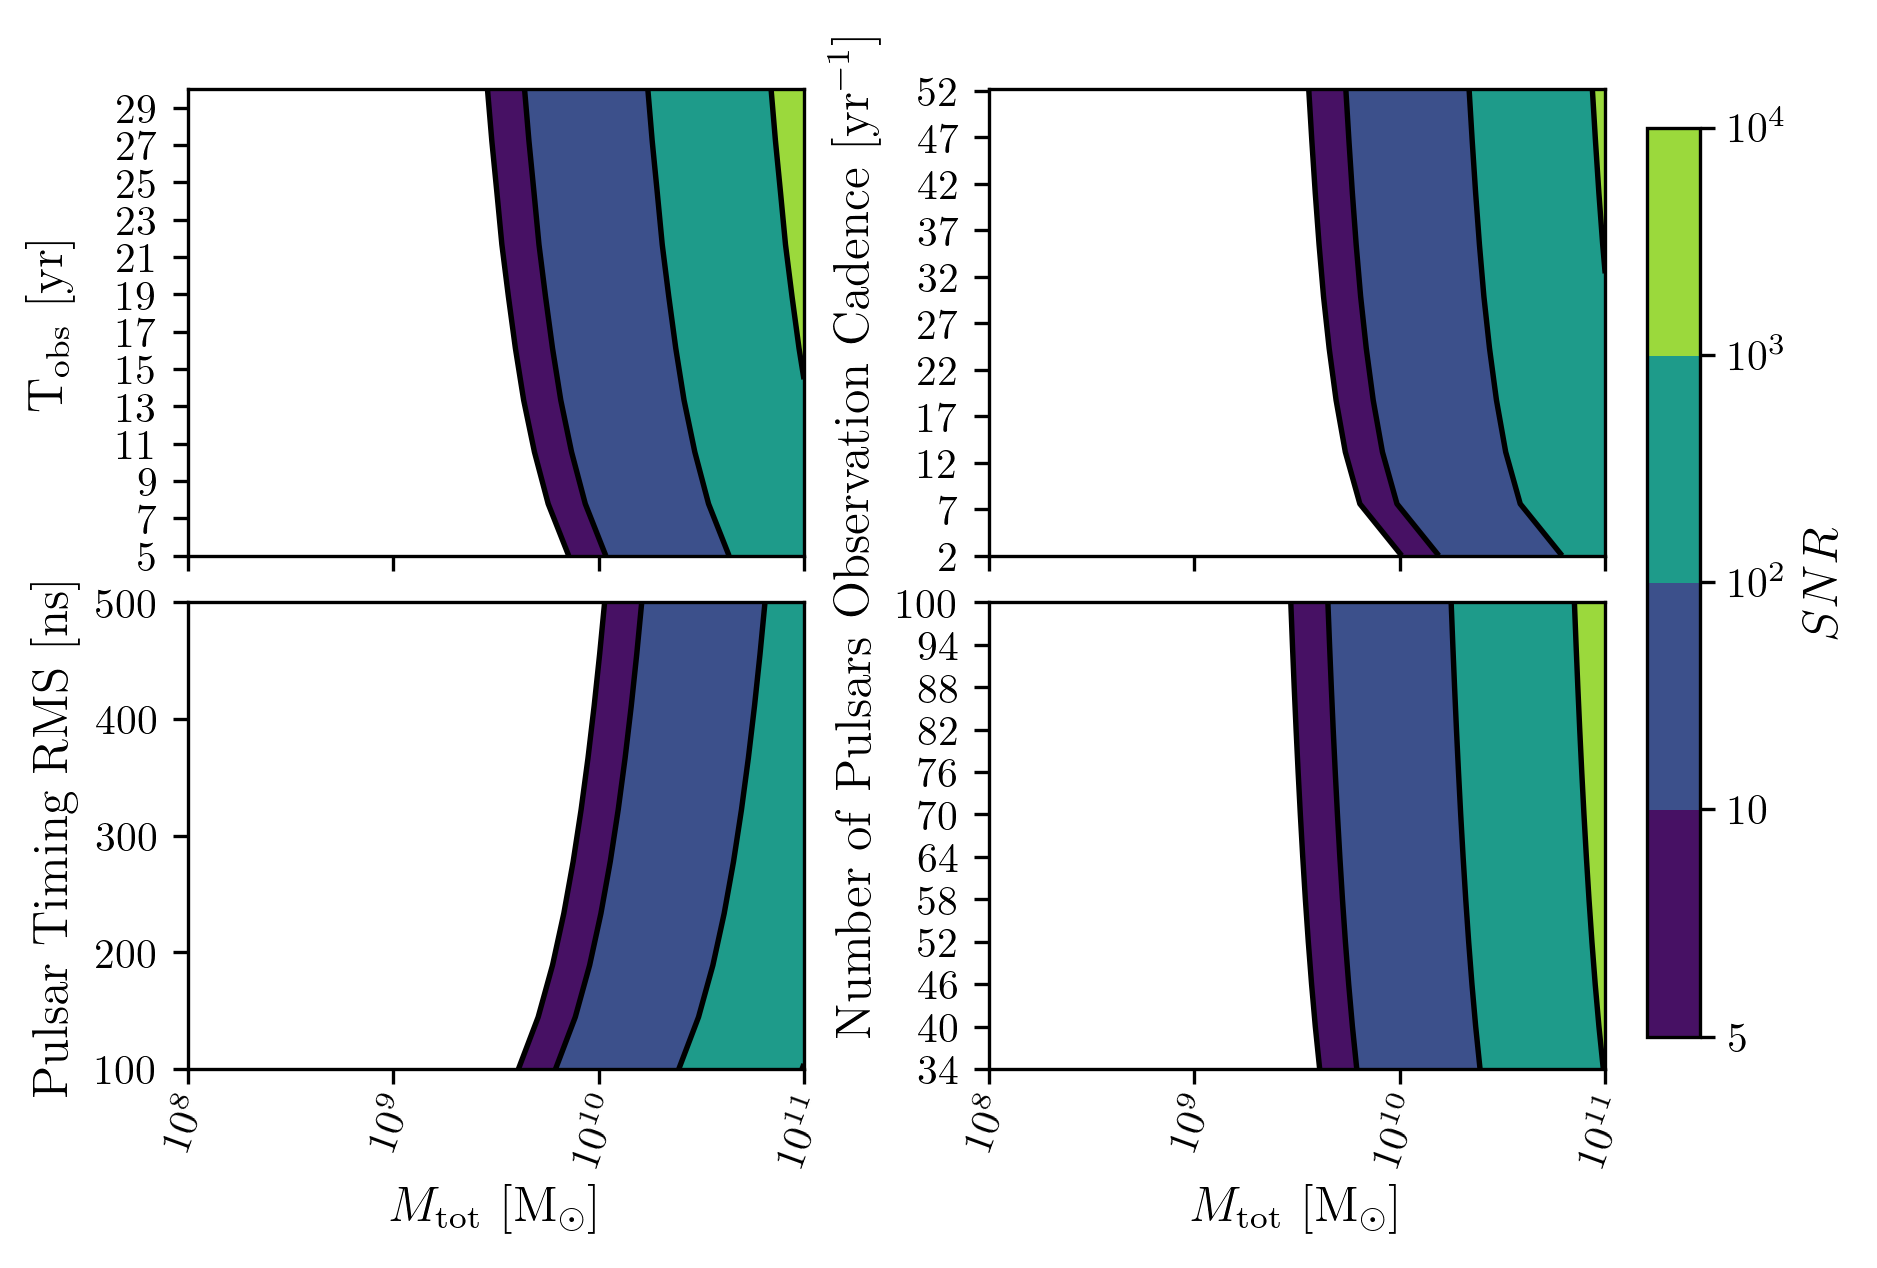

In [114]:
#########################
#Make the Contour Plots

figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)

samples = [NANOGrav_WN_Samples_M_vs_T_obs,NANOGrav_WN_Samples_M_vs_cadence,
           NANOGrav_WN_Samples_M_vs_sigma,NANOGrav_WN_Samples_M_vs_N_p_x,NANOGrav_WN_Samples_M_vs_N_p_y]
SNRs = [NANOGrav_WN_SNR_M_vs_T_obs,NANOGrav_WN_SNR_M_vs_cadence,
        NANOGrav_WN_SNR_M_vs_sigma,NANOGrav_WN_SNR_M_vs_N_p]
var_ys = ['T_obs','cadence','sigma','N_p']
loglevelMin=-1.0
loglevelMax=4.0
hspace = .1
wspace = .3
y_label_loc = -.175

ii = 0
for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if ii == (np.shape(axes)[0]*np.shape(axes)[1])-1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii],var_ys[ii],samples[ii+1],
                 SNRs[ii],display=True,display_cbar=True,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        elif ii == (np.shape(axes)[0]*np.shape(axes)[1])-2:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],var_ys[ii],samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     logLevels_min=loglevelMin,logLevels_max=loglevelMax,
                     hspace=hspace,wspace=wspace,y_label_loc=y_label_loc)
        ii += 1
        
fig.savefig(save_directory+'SNR_NANOGrav_WN_M_vs_params.pdf',bbox_inches='tight')

#### NANOGrav WN + GWB

In [115]:
[NANOGrav_WN_GWB_Samples_M_vs_N_p_x,NANOGrav_WN_GWB_Samples_M_vs_N_p_y,
 NANOGrav_WN_GWB_SNR_M_vs_N_p] = load_stuff('NANOGrav_WN_GWB','M','N_p',version)

[NANOGrav_WN_GWB_Samples_M_vs_T_obs,NANOGrav_WN_GWB_SNR_M_vs_T_obs] = load_stuff('NANOGrav_WN_GWB','M','T_obs',version)
[NANOGrav_WN_GWB_Samples_M_vs_cadence,NANOGrav_WN_GWB_SNR_M_vs_cadence] = load_stuff('NANOGrav_WN_GWB','M','cadence',version)
[NANOGrav_WN_GWB_Samples_M_vs_q,NANOGrav_WN_GWB_SNR_M_vs_q] = load_stuff('NANOGrav_WN_GWB','M','q',version)
[NANOGrav_WN_GWB_Samples_M_vs_chi1,NANOGrav_WN_GWB_SNR_M_vs_chi1] = load_stuff('NANOGrav_WN_GWB','M','chi1',version)
[NANOGrav_WN_GWB_Samples_M_vs_sigma,NANOGrav_WN_GWB_SNR_M_vs_sigma] = load_stuff('NANOGrav_WN_GWB','M','sigma',version)
[NANOGrav_WN_GWB_Samples_M_vs_z,NANOGrav_WN_GWB_SNR_M_vs_z] = load_stuff('NANOGrav_WN_GWB','M','z',version)

#### NANOGrav WN + RN

In [116]:
version_WN_RN = 'v1'
[NANOGrav_WN_RN_Samples_M_vs_N_p_x,NANOGrav_WN_RN_Samples_M_vs_N_p_y,
 NANOGrav_WN_RN_SNR_M_vs_N_p] = load_stuff('NANOGrav_WN_RN','M','N_p',version_WN_RN)
[NANOGrav_WN_RN_Samples_M_vs_T_obs,NANOGrav_WN_RN_SNR_M_vs_T_obs] = load_stuff('NANOGrav_WN_RN','M','T_obs',version_WN_RN)
[NANOGrav_WN_RN_Samples_M_vs_cadence,NANOGrav_WN_RN_SNR_M_vs_cadence] = load_stuff('NANOGrav_WN_RN','M','cadence',version_WN_RN)
[NANOGrav_WN_RN_Samples_M_vs_q,NANOGrav_WN_RN_SNR_M_vs_q] = load_stuff('NANOGrav_WN_RN','M','q',version_WN_RN)
[NANOGrav_WN_RN_Samples_M_vs_chi1,NANOGrav_WN_RN_SNR_M_vs_chi1] = load_stuff('NANOGrav_WN_RN','M','chi1',version_WN_RN)
[NANOGrav_WN_RN_Samples_M_vs_sigma,NANOGrav_WN_RN_SNR_M_vs_sigma] = load_stuff('NANOGrav_WN_RN','M','sigma',version_WN_RN)
[NANOGrav_WN_RN_Samples_M_vs_z,NANOGrav_WN_RN_SNR_M_vs_z] = load_stuff('NANOGrav_WN_RN','M','z',version_WN_RN)

#### NANOGrav Realistic Noise

In [117]:
[NANOGrav_realistic_noise_Samples_M_vs_N_p_x,NANOGrav_realistic_noise_Samples_M_vs_N_p_y,
 NANOGrav_realistic_noise_SNR_M_vs_N_p] = load_stuff('NANOGrav_realistic_noise','M','N_p',version)
[NANOGrav_realistic_noise_Samples_M_vs_T_obs,NANOGrav_realistic_noise_SNR_M_vs_T_obs] = load_stuff('NANOGrav_realistic_noise','M','T_obs',version)
[NANOGrav_realistic_noise_Samples_M_vs_cadence,NANOGrav_realistic_noise_SNR_M_vs_cadence] = load_stuff('NANOGrav_realistic_noise','M','cadence',version)
[NANOGrav_realistic_noise_Samples_M_vs_q,NANOGrav_realistic_noise_SNR_M_vs_q] = load_stuff('NANOGrav_realistic_noise','M','q',version)
[NANOGrav_realistic_noise_Samples_M_vs_chi1,NANOGrav_realistic_noise_SNR_M_vs_chi1] = load_stuff('NANOGrav_realistic_noise','M','chi1',version)
[NANOGrav_realistic_noise_Samples_M_vs_sigma,NANOGrav_realistic_noise_SNR_M_vs_sigma] = load_stuff('NANOGrav_realistic_noise','M','sigma',version)
[NANOGrav_realistic_noise_Samples_M_vs_z,NANOGrav_realistic_noise_SNR_M_vs_z] = load_stuff('NANOGrav_realistic_noise','M','z',version)

#### NANOGrav 11yr

In [118]:
[NANOGrav_11yr_Samples_M_vs_q,NANOGrav_11yr_SNR_M_vs_q] = load_stuff('NANOGrav_11yr','M','q',version)
[NANOGrav_11yr_Samples_M_vs_chi1,NANOGrav_11yr_SNR_M_vs_chi1] = load_stuff('NANOGrav_11yr','M','chi1',version)
[NANOGrav_11yr_Samples_M_vs_z,NANOGrav_11yr_SNR_M_vs_z] = load_stuff('NANOGrav_11yr','M','z',version)

### NANOGrav Model Comparison Plots

M vs. q

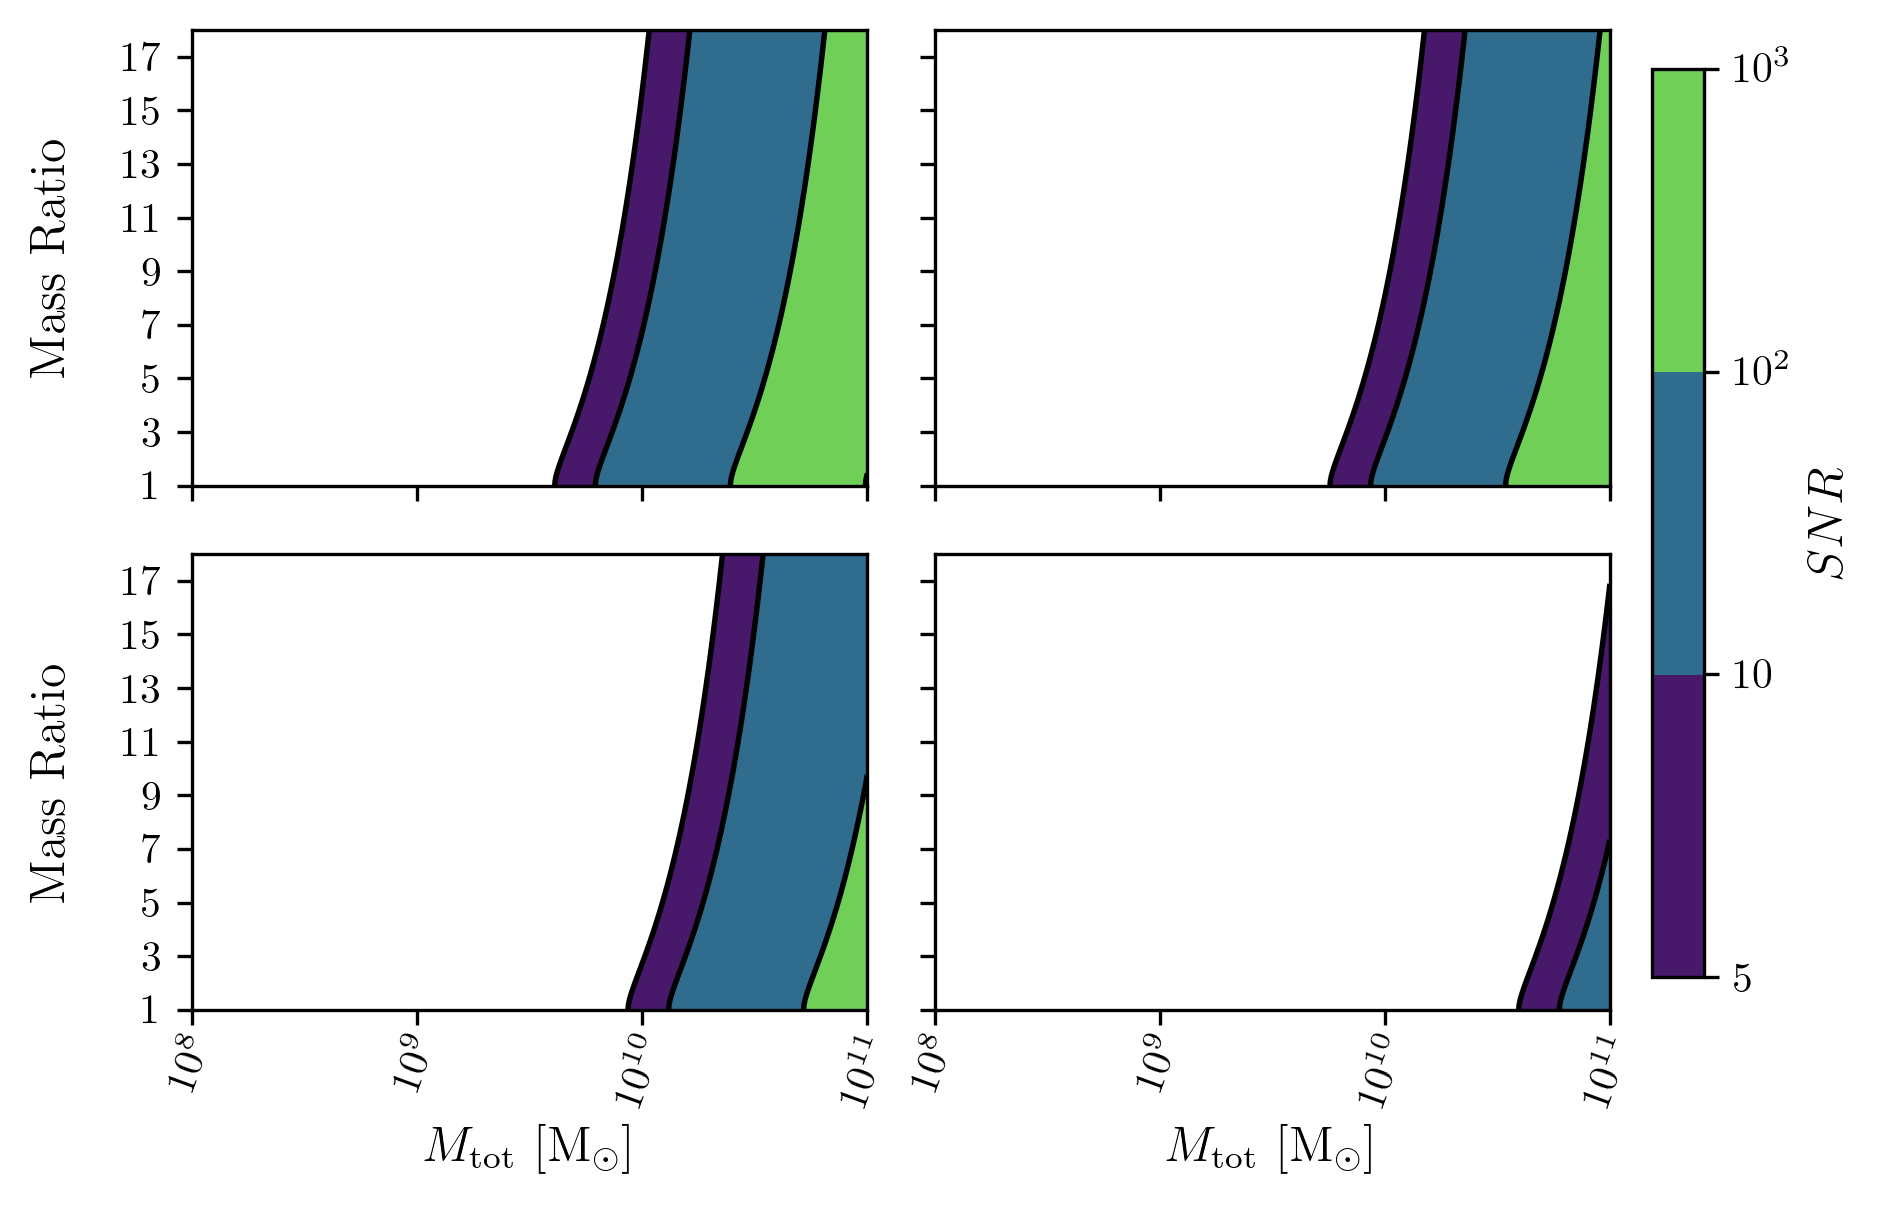

In [119]:
#########################
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [NANOGrav_WN_Samples_M_vs_q,NANOGrav_WN_GWB_Samples_M_vs_q,
           NANOGrav_realistic_noise_Samples_M_vs_q,NANOGrav_11yr_Samples_M_vs_q]
SNRs = [NANOGrav_WN_SNR_M_vs_q,NANOGrav_WN_GWB_SNR_M_vs_q,
        NANOGrav_realistic_noise_SNR_M_vs_q,NANOGrav_11yr_SNR_M_vs_q]
loglevelMax=3.0
y_label_loc = -.175

ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        ii += 1

M vs. z

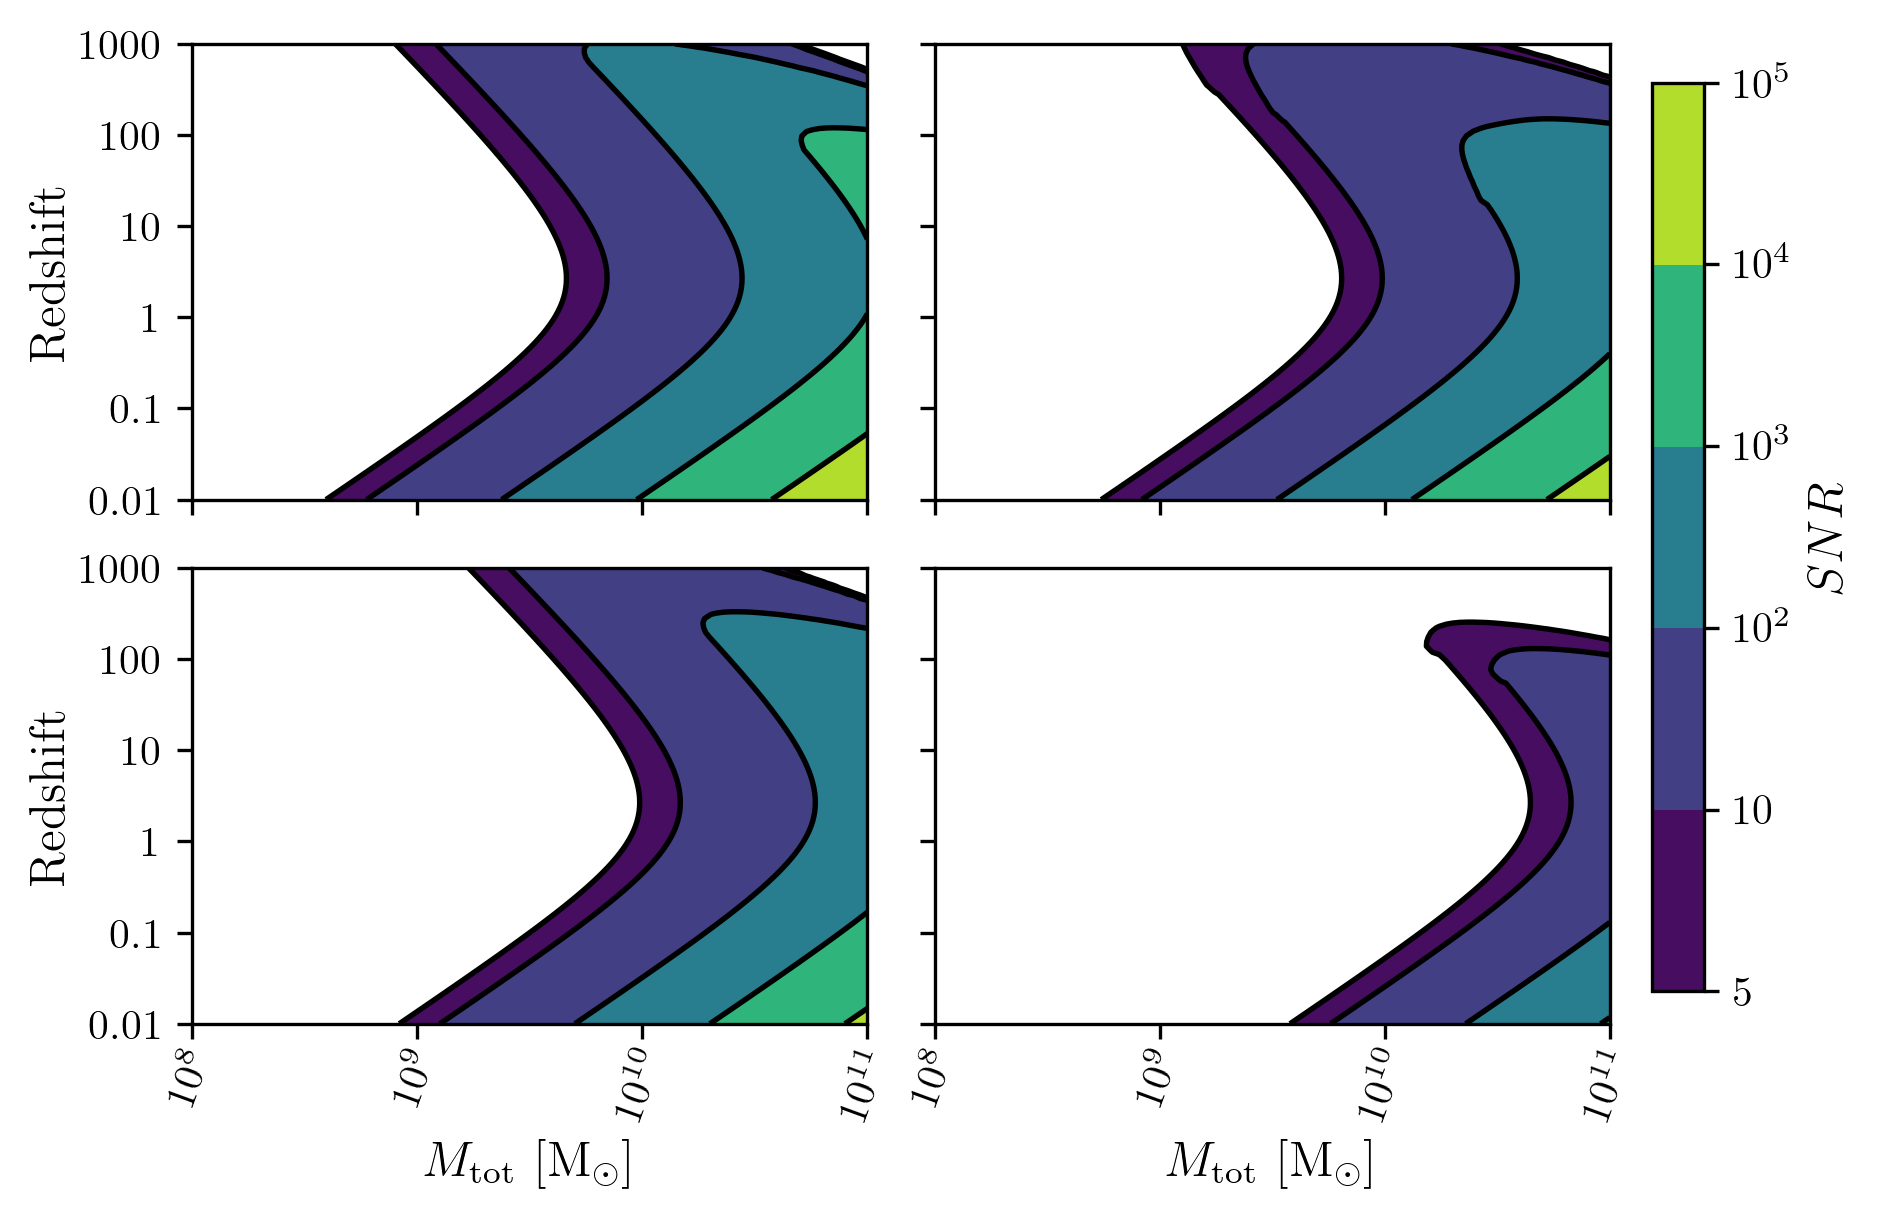

In [120]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [NANOGrav_WN_Samples_M_vs_z,NANOGrav_WN_GWB_Samples_M_vs_z,
           NANOGrav_realistic_noise_Samples_M_vs_z,NANOGrav_11yr_Samples_M_vs_z]
SNRs = [NANOGrav_WN_SNR_M_vs_z,NANOGrav_WN_GWB_SNR_M_vs_z,
        NANOGrav_realistic_noise_SNR_M_vs_z,NANOGrav_11yr_SNR_M_vs_z]
loglevelMax=5.0
y_label_loc = -.175

ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        ii += 1
fig.savefig(save_directory+'SNR_NANOGrav_model_comp_M_vs_z.pdf',bbox_inches='tight')

M vs chi1

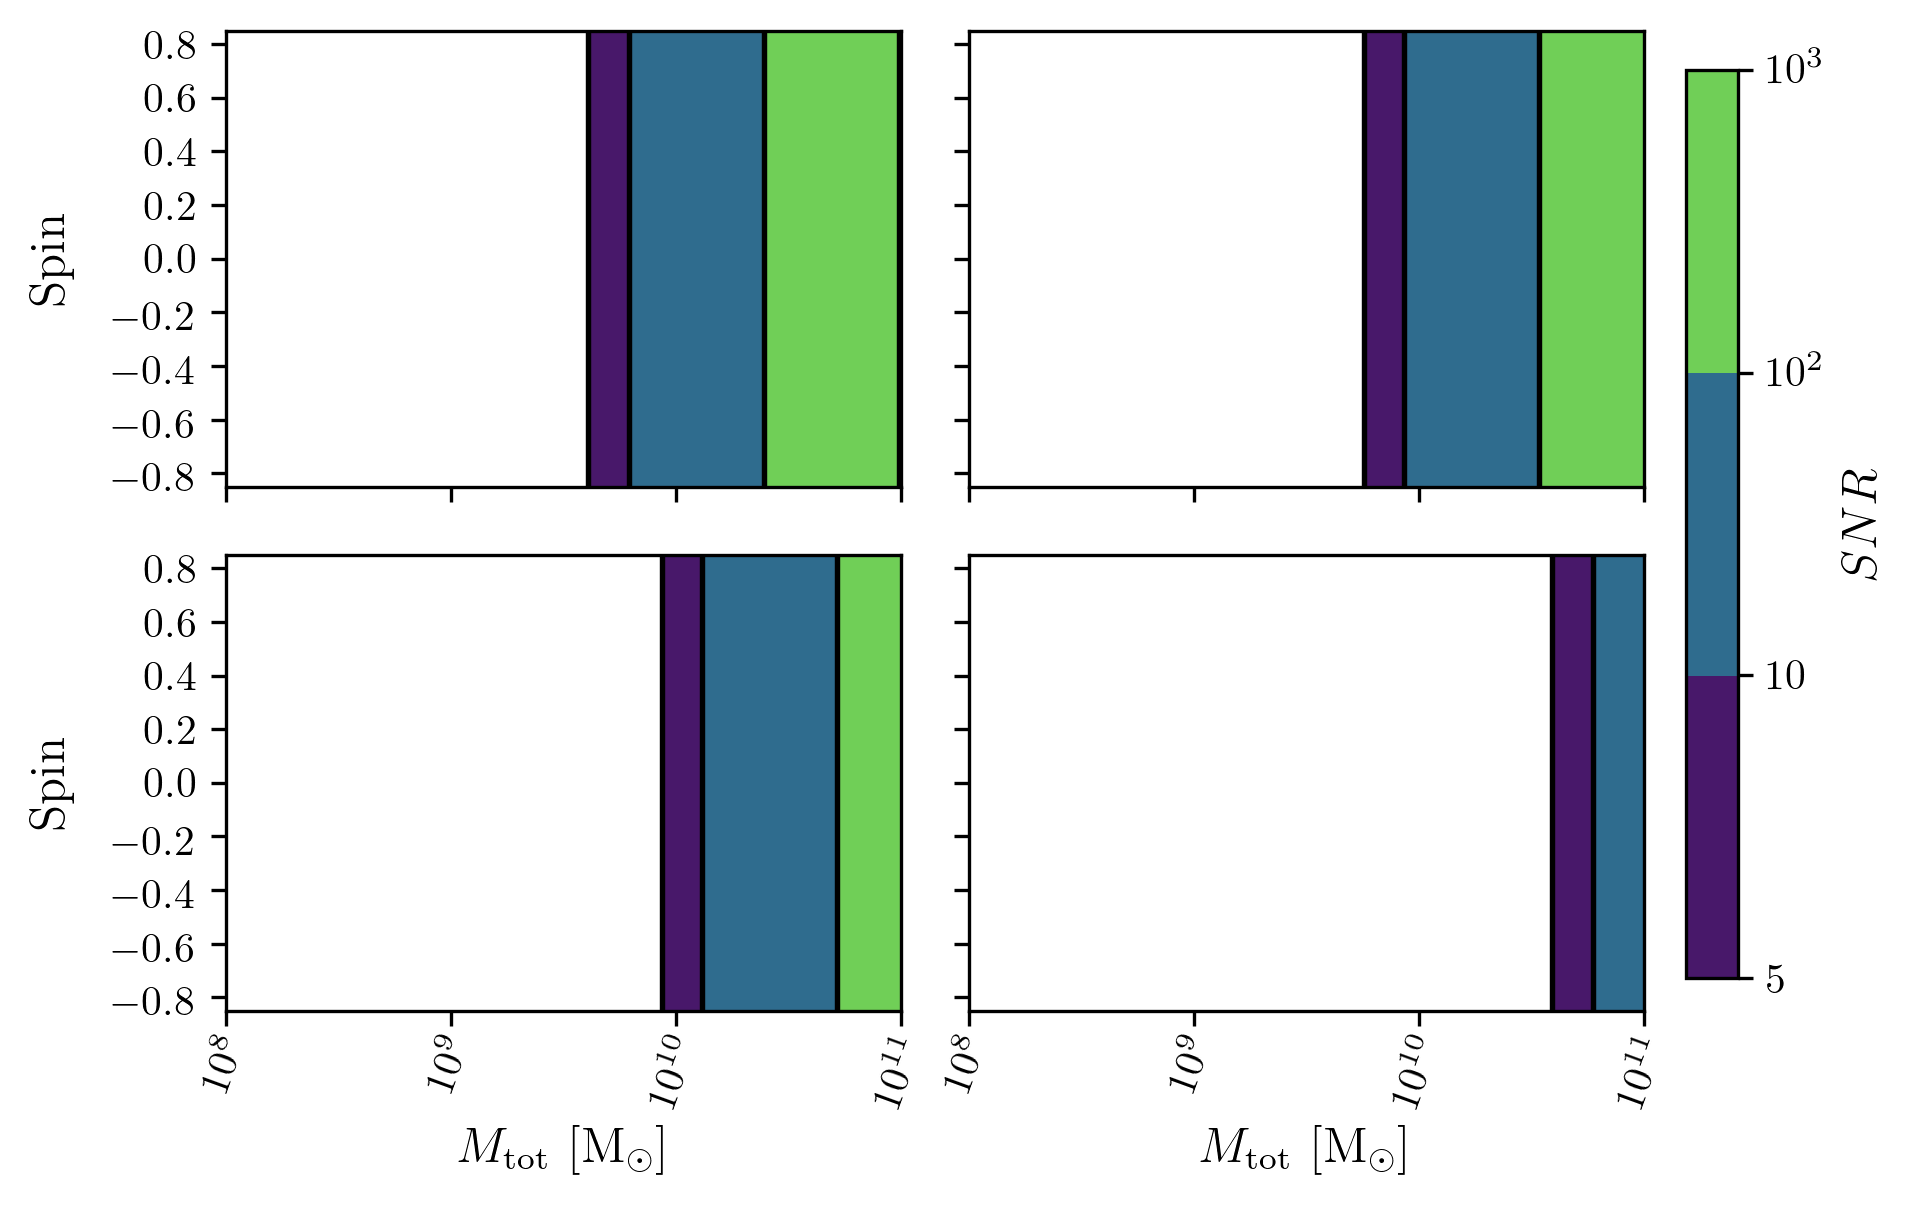

In [22]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [NANOGrav_WN_Samples_M_vs_chi1,NANOGrav_WN_GWB_Samples_M_vs_chi1,
           NANOGrav_realistic_noise_Samples_M_vs_chi1,NANOGrav_11yr_Samples_M_vs_chi1]
SNRs = [NANOGrav_WN_SNR_M_vs_chi1,NANOGrav_WN_GWB_SNR_M_vs_chi1,
        NANOGrav_realistic_noise_SNR_M_vs_chi1,NANOGrav_11yr_SNR_M_vs_chi1]
loglevelMax=3.0
y_label_loc = -.175

ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        ii += 1

M vs. N_p

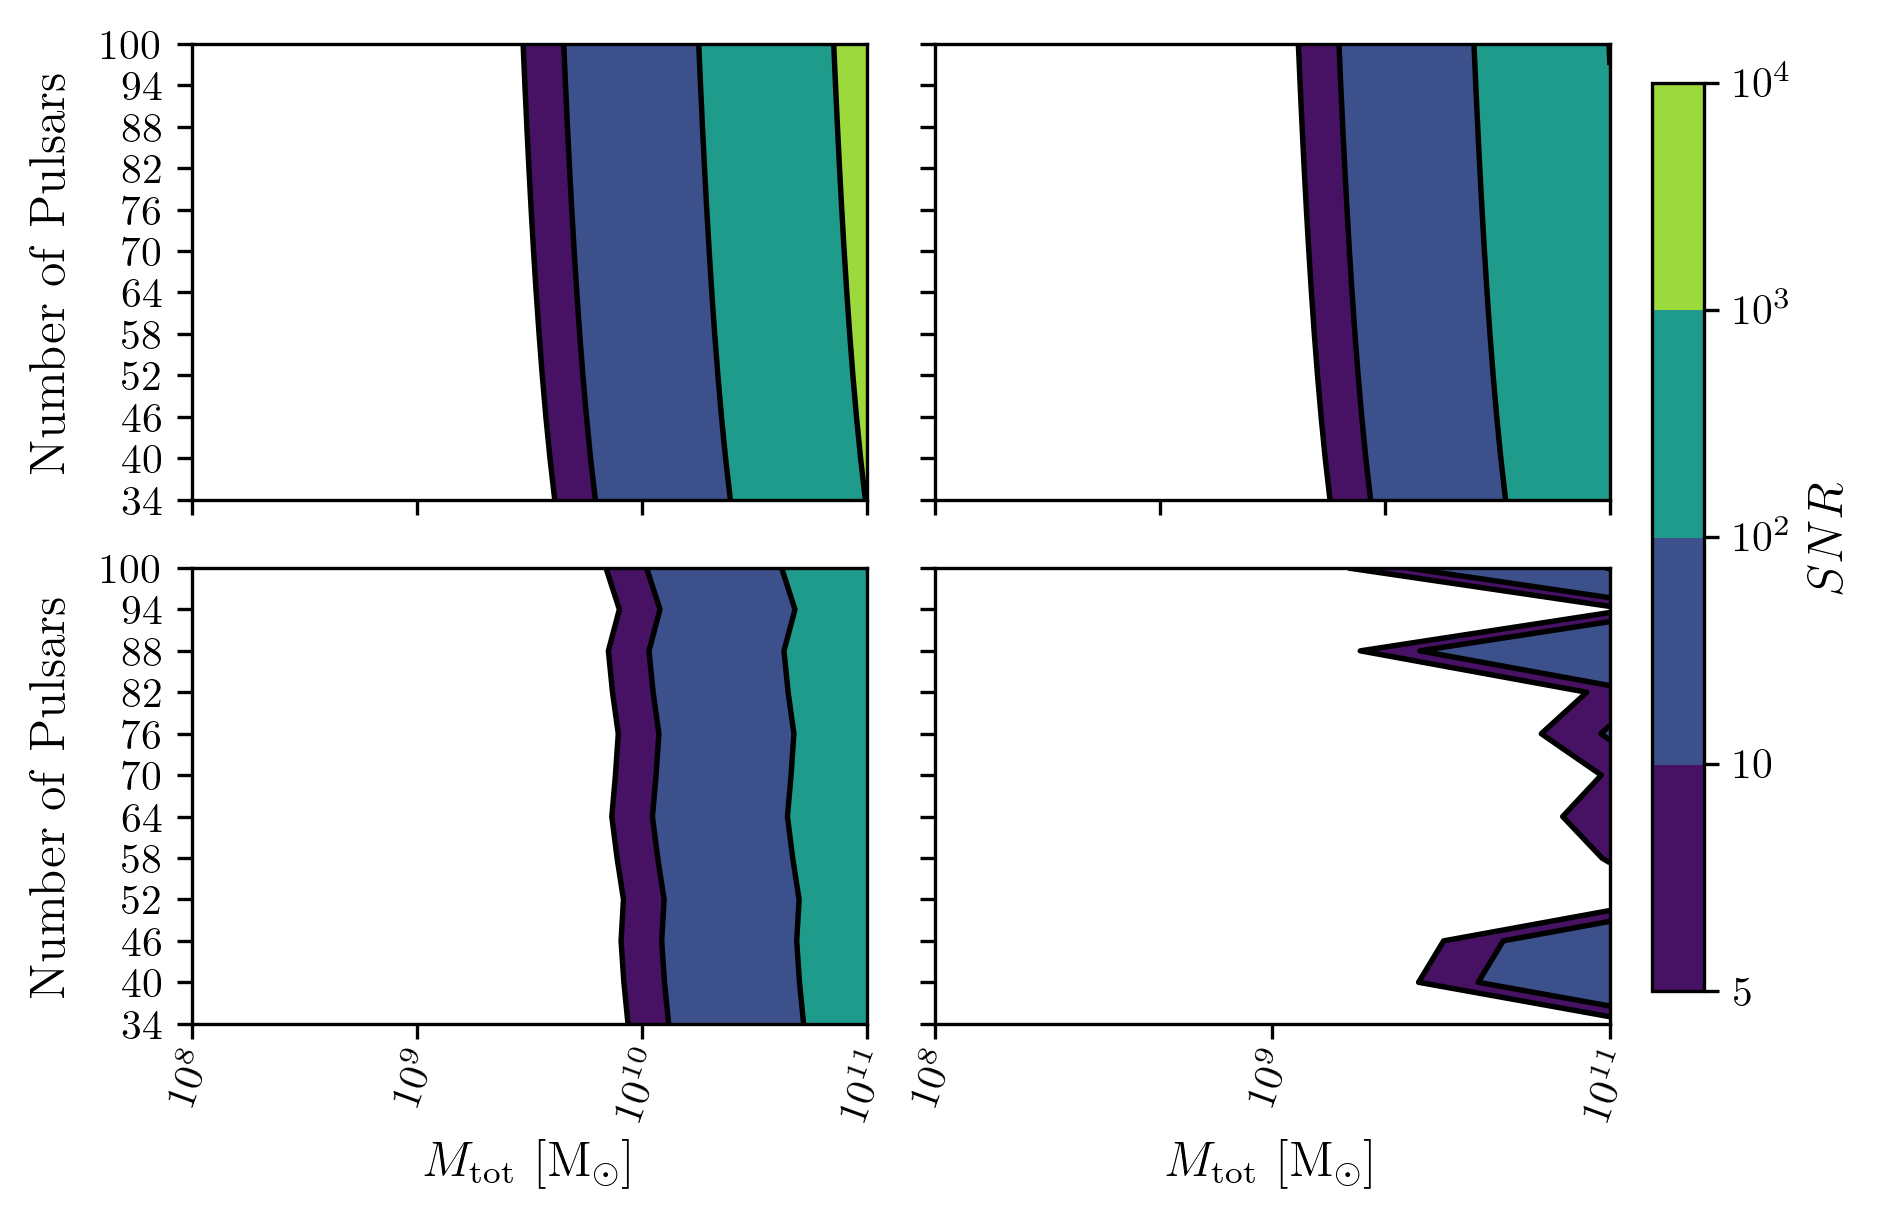

In [23]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples_x = [NANOGrav_WN_Samples_M_vs_N_p_x,NANOGrav_WN_GWB_Samples_M_vs_N_p_x,
             NANOGrav_realistic_noise_Samples_M_vs_N_p_x,NANOGrav_WN_RN_Samples_M_vs_N_p_x]
samples_y = [NANOGrav_WN_Samples_M_vs_N_p_y,NANOGrav_WN_GWB_Samples_M_vs_N_p_y,
             NANOGrav_realistic_noise_Samples_M_vs_N_p_y,NANOGrav_WN_RN_Samples_M_vs_N_p_y]
SNRs = [NANOGrav_WN_SNR_M_vs_N_p,NANOGrav_WN_GWB_SNR_M_vs_N_p,
        NANOGrav_realistic_noise_SNR_M_vs_N_p,NANOGrav_WN_RN_SNR_M_vs_N_p]
loglevelMax=4.0
y_label_loc = -.175
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        ii += 1

M vs cadence

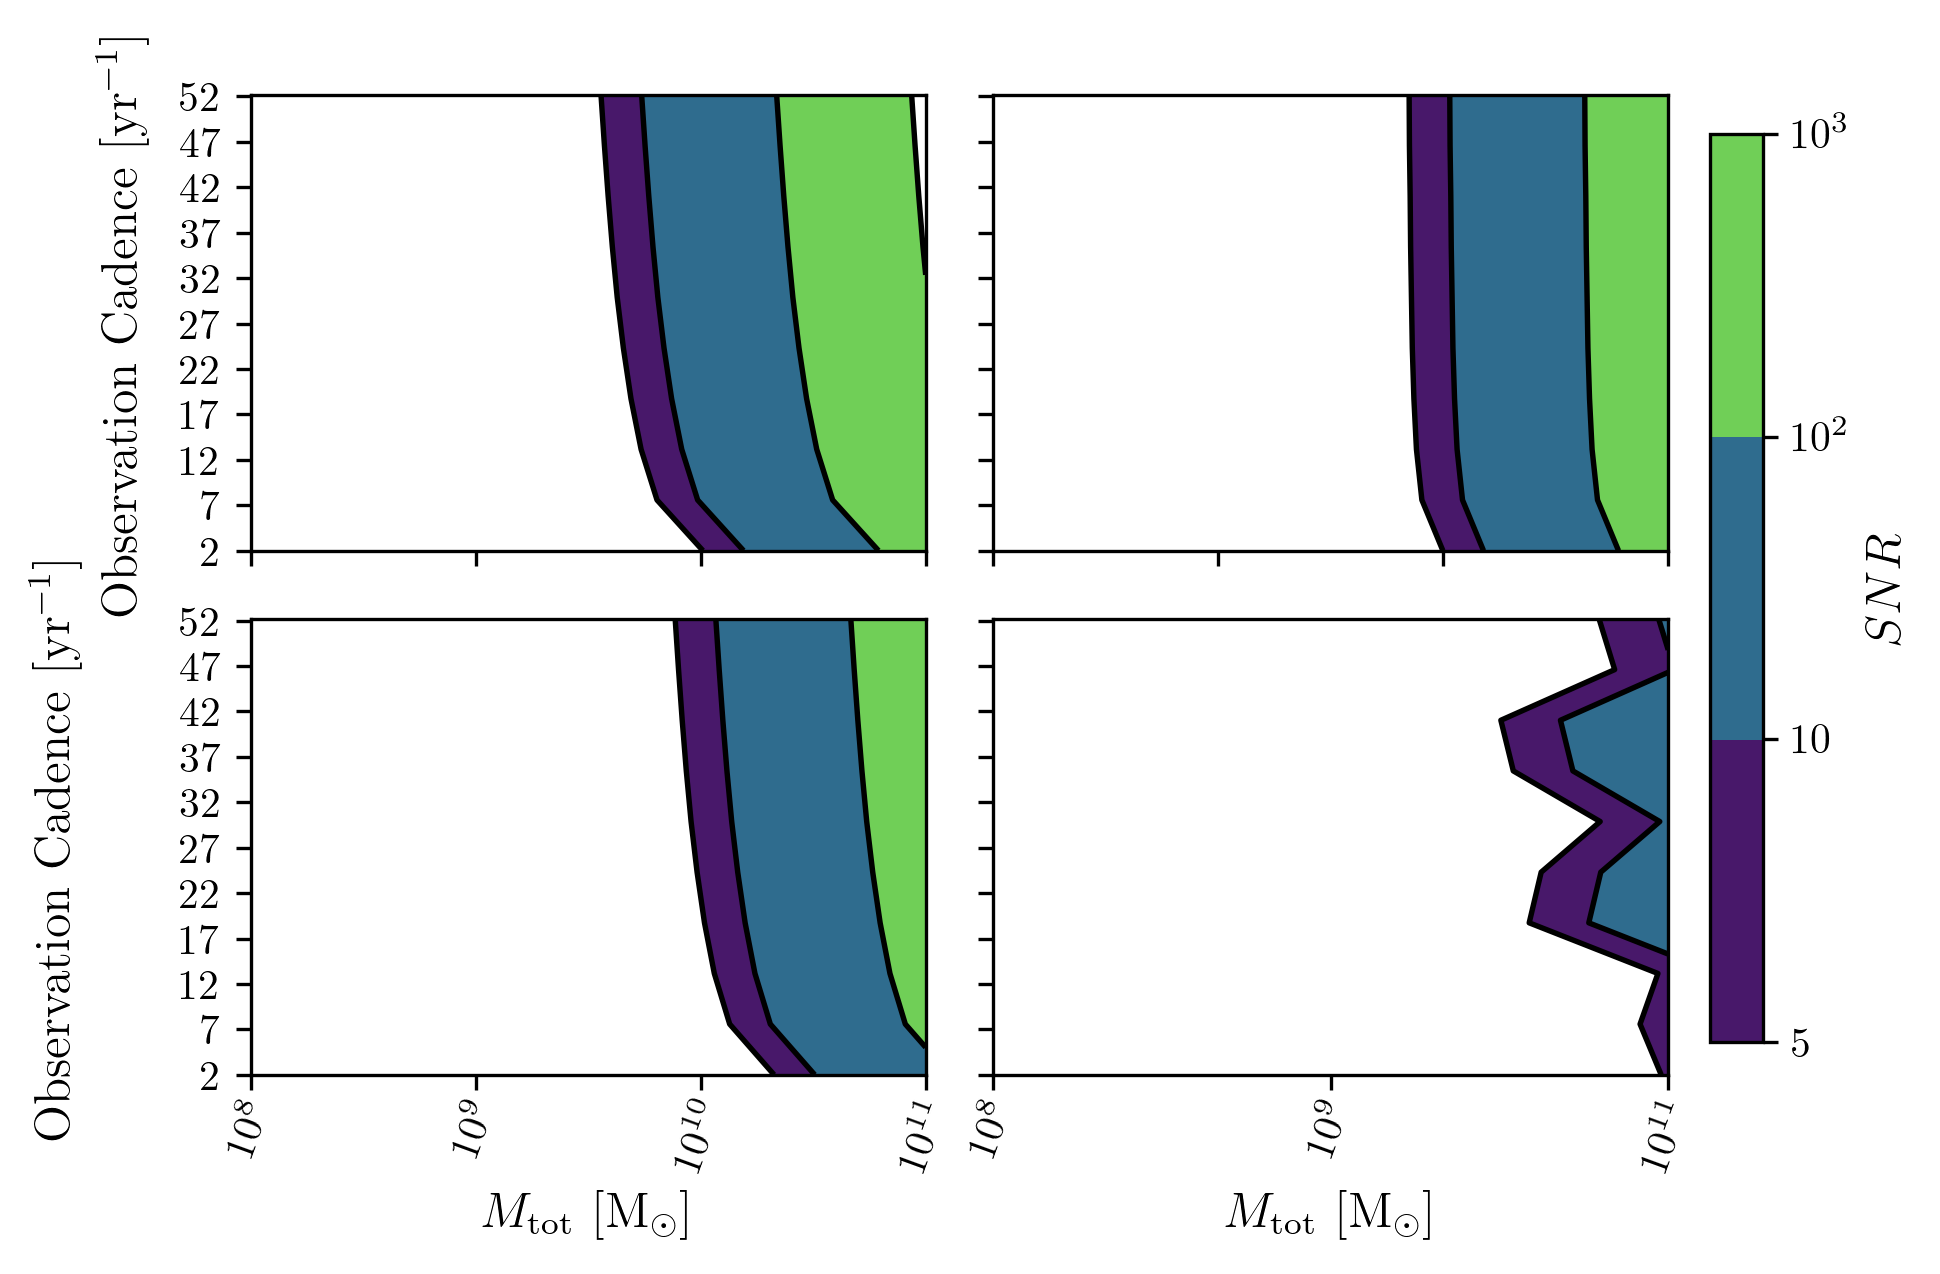

In [99]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [NANOGrav_WN_Samples_M_vs_cadence,NANOGrav_WN_GWB_Samples_M_vs_cadence,
           NANOGrav_realistic_noise_Samples_M_vs_cadence,NANOGrav_WN_RN_Samples_M_vs_cadence]
SNRs = [NANOGrav_WN_SNR_M_vs_cadence,NANOGrav_WN_GWB_SNR_M_vs_cadence,
        NANOGrav_realistic_noise_SNR_M_vs_cadence,NANOGrav_WN_RN_SNR_M_vs_cadence]
loglevelMax=3.0
y_label_loc = -.15
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc-.1)
        ii += 1

M vs T_obs

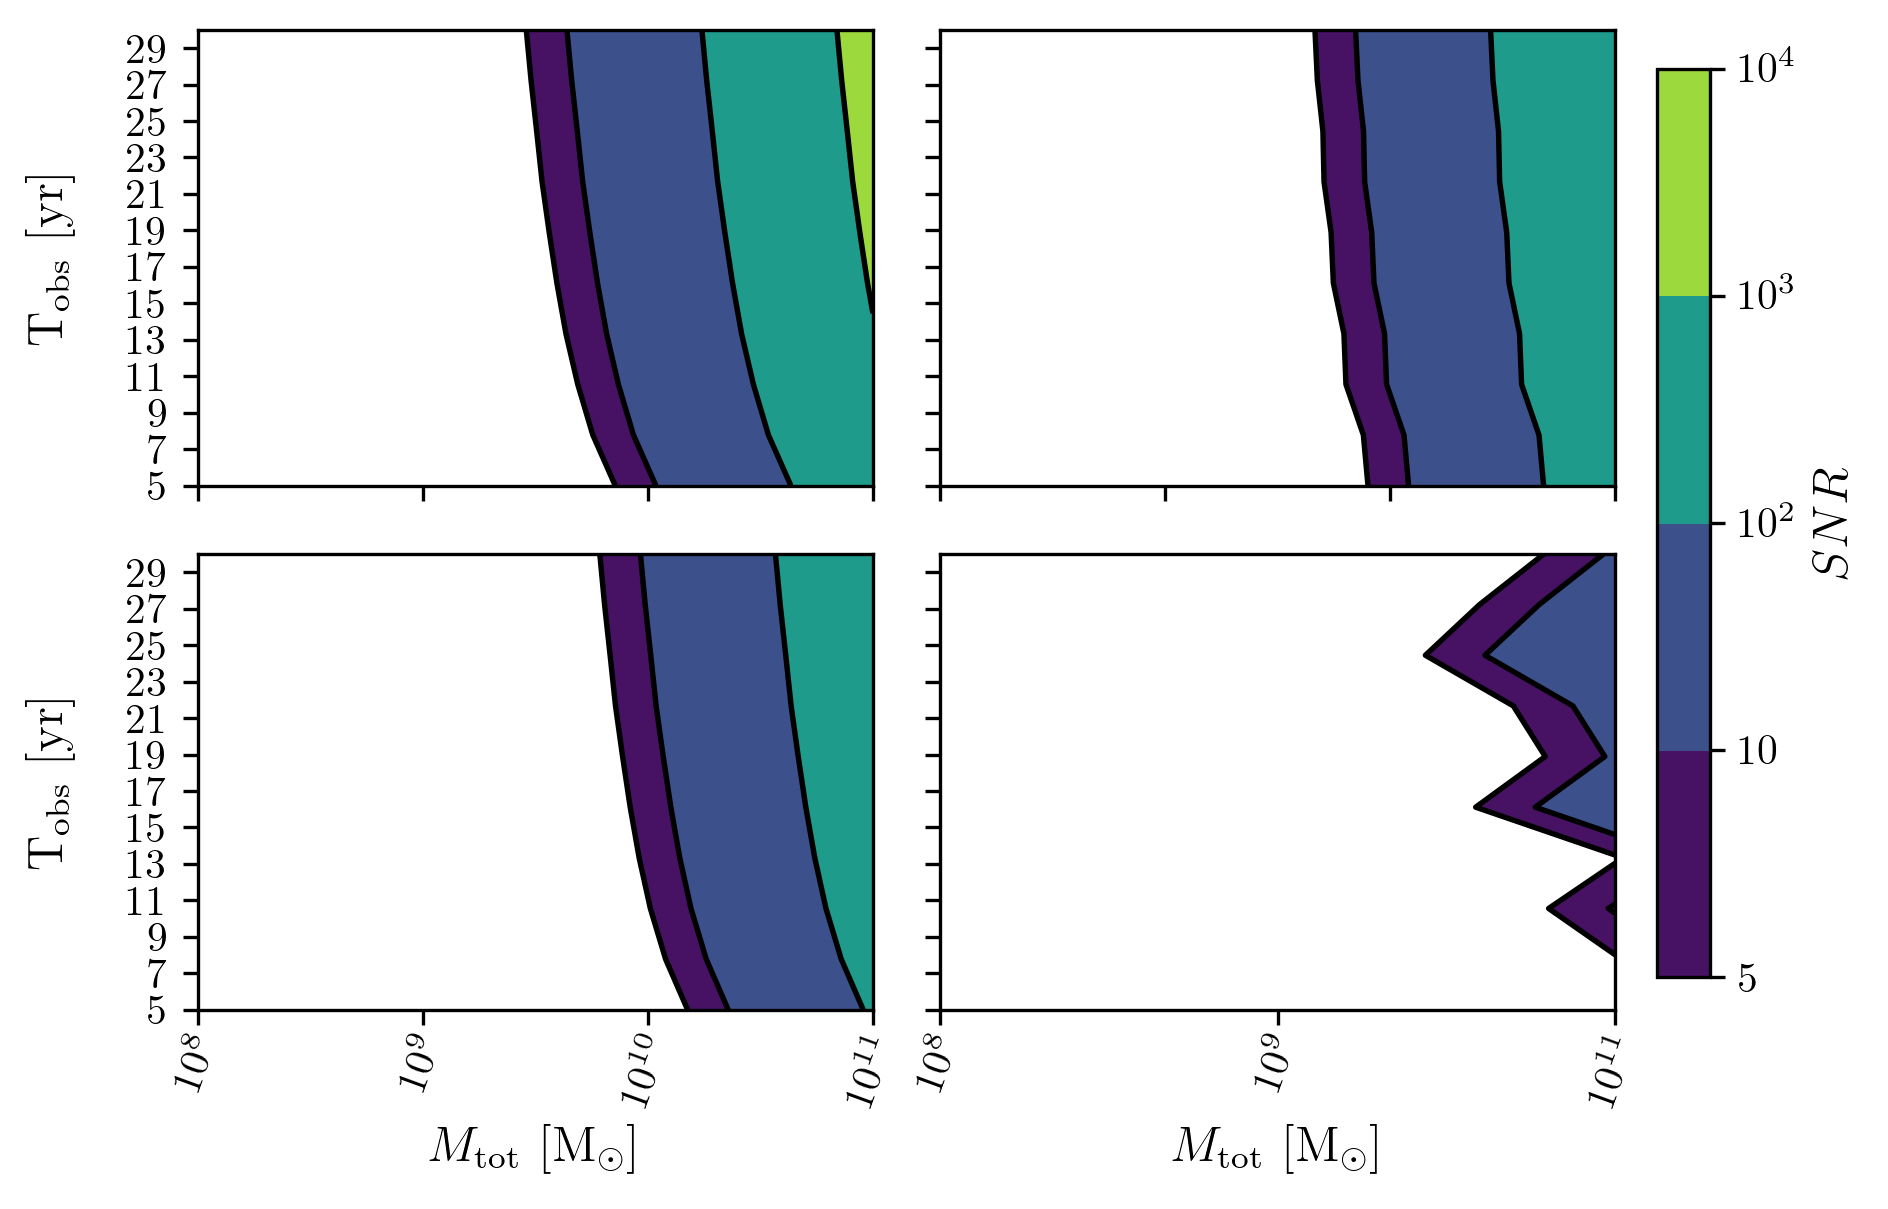

In [25]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [NANOGrav_WN_Samples_M_vs_T_obs,NANOGrav_WN_GWB_Samples_M_vs_T_obs,
           NANOGrav_realistic_noise_Samples_M_vs_T_obs,NANOGrav_WN_RN_Samples_M_vs_T_obs]
SNRs = [NANOGrav_WN_SNR_M_vs_T_obs,NANOGrav_WN_GWB_SNR_M_vs_T_obs,
        NANOGrav_realistic_noise_SNR_M_vs_T_obs,NANOGrav_WN_RN_SNR_M_vs_T_obs]
loglevelMax=4.0
y_label_loc = -.175
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        ii += 1

M vs sigma

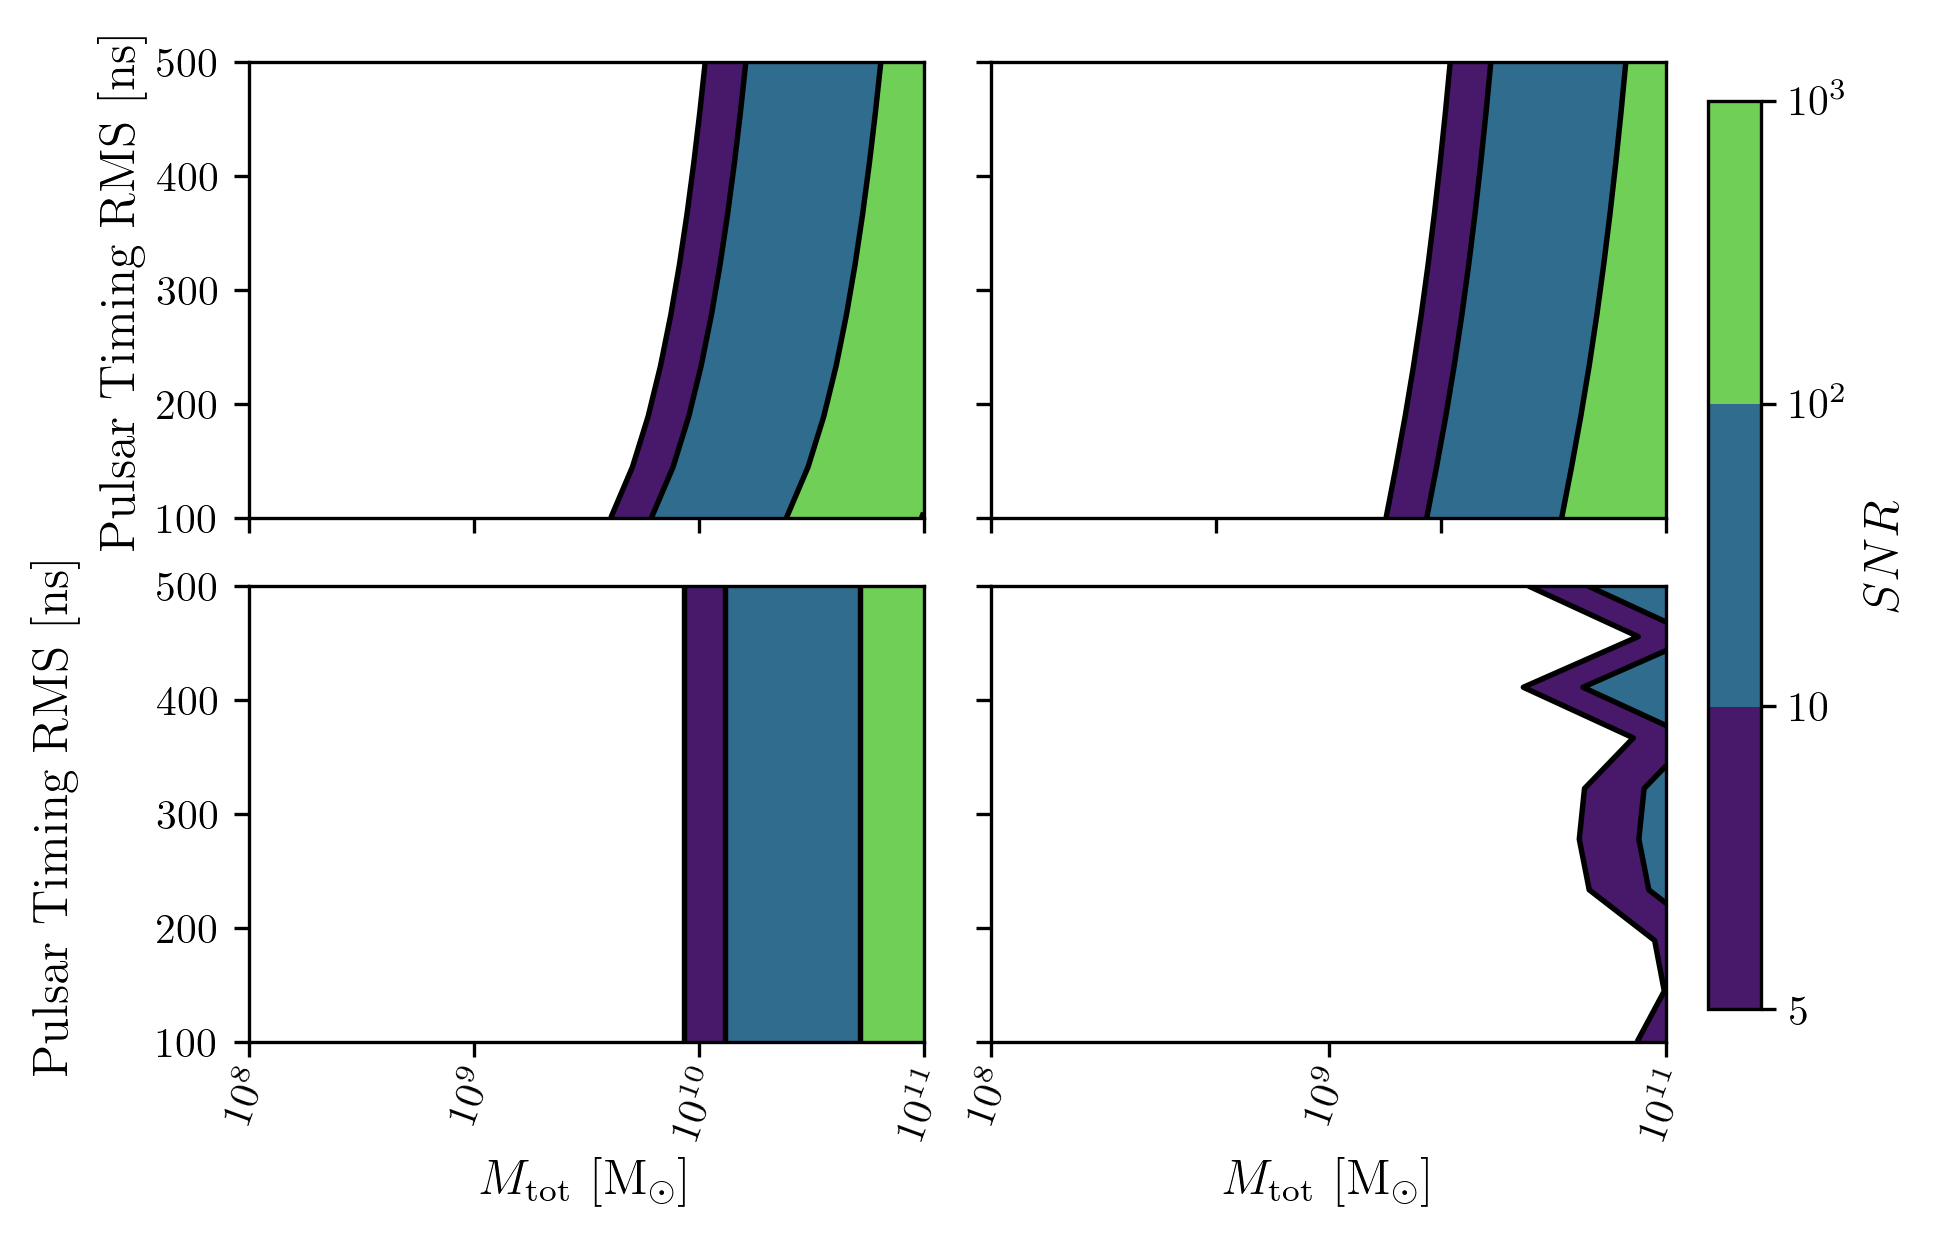

In [98]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [NANOGrav_WN_Samples_M_vs_sigma,NANOGrav_WN_GWB_Samples_M_vs_sigma,
           NANOGrav_realistic_noise_Samples_M_vs_sigma,NANOGrav_WN_RN_Samples_M_vs_sigma]
SNRs = [NANOGrav_WN_SNR_M_vs_sigma,NANOGrav_WN_GWB_SNR_M_vs_sigma,
        NANOGrav_realistic_noise_SNR_M_vs_sigma,NANOGrav_WN_RN_SNR_M_vs_sigma]
loglevelMax=3.0
y_label_loc = -.15
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=False,
                     y_axis_label=False,logLevels_max=loglevelMax)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,y_label_loc=y_label_loc-.1)
        ii += 1

#### SKA WN Only

In [121]:
[SKA_WN_Samples_M_vs_N_p_x,SKA_WN_Samples_M_vs_N_p_y,SKA_WN_SNR_M_vs_N_p] = load_stuff('SKA_WN','M','N_p',version)
[SKA_WN_Samples_M_vs_T_obs,SKA_WN_SNR_M_vs_T_obs] = load_stuff('SKA_WN','M','T_obs',version)
[SKA_WN_Samples_M_vs_cadence,SKA_WN_SNR_M_vs_cadence] = load_stuff('SKA_WN','M','cadence',version)
[SKA_WN_Samples_M_vs_q,SKA_WN_SNR_M_vs_q] = load_stuff('SKA_WN','M','q',version)
[SKA_WN_Samples_M_vs_chi1,SKA_WN_SNR_M_vs_chi1] = load_stuff('SKA_WN','M','chi1',version)
[SKA_WN_Samples_M_vs_sigma,SKA_WN_SNR_M_vs_sigma] = load_stuff('SKA_WN','M','sigma',version)
[SKA_WN_Samples_M_vs_z,SKA_WN_SNR_M_vs_z] = load_stuff('SKA_WN','M','z',version)

#### SKA WN + RN

In [122]:
[SKA_WN_RN_Samples_M_vs_N_p_x,SKA_WN_RN_Samples_M_vs_N_p_y,SKA_WN_RN_SNR_M_vs_N_p] = load_stuff('SKA_WN_RN','M','N_p',version_WN_RN)
[SKA_WN_RN_Samples_M_vs_T_obs,SKA_WN_RN_SNR_M_vs_T_obs] = load_stuff('SKA_WN_RN','M','T_obs',version_WN_RN)
[SKA_WN_RN_Samples_M_vs_cadence,SKA_WN_RN_SNR_M_vs_cadence] = load_stuff('SKA_WN_RN','M','cadence',version_WN_RN)
[SKA_WN_RN_Samples_M_vs_q,SKA_WN_RN_SNR_M_vs_q] = load_stuff('SKA_WN_RN','M','q',version_WN_RN)
[SKA_WN_RN_Samples_M_vs_chi1,SKA_WN_RN_SNR_M_vs_chi1] = load_stuff('SKA_WN_RN','M','chi1',version_WN_RN)
[SKA_WN_RN_Samples_M_vs_sigma,SKA_WN_RN_SNR_M_vs_sigma] = load_stuff('SKA_WN_RN','M','sigma',version_WN_RN)
[SKA_WN_RN_Samples_M_vs_z,SKA_WN_RN_SNR_M_vs_z] = load_stuff('SKA_WN_RN','M','z',version_WN_RN)

#### SKA WN + GWB

In [123]:
[SKA_WN_GWB_Samples_M_vs_N_p_x,SKA_WN_GWB_Samples_M_vs_N_p_y,
 SKA_WN_GWB_SNR_M_vs_N_p] = load_stuff('SKA_WN_GWB','M','N_p',version)
[SKA_WN_GWB_Samples_M_vs_T_obs,SKA_WN_GWB_SNR_M_vs_T_obs] = load_stuff('SKA_WN_GWB','M','T_obs',version)
[SKA_WN_GWB_Samples_M_vs_cadence,SKA_WN_GWB_SNR_M_vs_cadence] = load_stuff('SKA_WN_GWB','M','cadence',version)
[SKA_WN_GWB_Samples_M_vs_q,SKA_WN_GWB_SNR_M_vs_q] = load_stuff('SKA_WN_GWB','M','q',version)
[SKA_WN_GWB_Samples_M_vs_chi1,SKA_WN_GWB_SNR_M_vs_chi1] = load_stuff('SKA_WN_GWB','M','chi1',version)
[SKA_WN_GWB_Samples_M_vs_sigma,SKA_WN_GWB_SNR_M_vs_sigma] = load_stuff('SKA_WN_GWB','M','sigma',version)
[SKA_WN_GWB_Samples_M_vs_z,SKA_WN_GWB_SNR_M_vs_z] = load_stuff('SKA_WN_GWB','M','z',version)

#### SKA Realistic Noise

In [124]:
[SKA_realistic_noise_Samples_M_vs_N_p_x,SKA_realistic_noise_Samples_M_vs_N_p_y,
 SKA_realistic_noise_SNR_M_vs_N_p] = load_stuff('SKA_realistic_noise','M','N_p',version)
[SKA_realistic_noise_Samples_M_vs_T_obs,SKA_realistic_noise_SNR_M_vs_T_obs] = load_stuff('SKA_realistic_noise','M','T_obs',version)
[SKA_realistic_noise_Samples_M_vs_cadence,SKA_realistic_noise_SNR_M_vs_cadence] = load_stuff('SKA_realistic_noise','M','cadence',version)
[SKA_realistic_noise_Samples_M_vs_q,SKA_realistic_noise_SNR_M_vs_q] = load_stuff('SKA_realistic_noise','M','q',version)
[SKA_realistic_noise_Samples_M_vs_chi1,SKA_realistic_noise_SNR_M_vs_chi1] = load_stuff('SKA_realistic_noise','M','chi1',version)
[SKA_realistic_noise_Samples_M_vs_sigma,SKA_realistic_noise_SNR_M_vs_sigma] = load_stuff('SKA_realistic_noise','M','sigma',version)
[SKA_realistic_noise_Samples_M_vs_z,SKA_realistic_noise_SNR_M_vs_z] = load_stuff('SKA_realistic_noise','M','z',version)

### SKA Model Comparison Plots

M vs. q

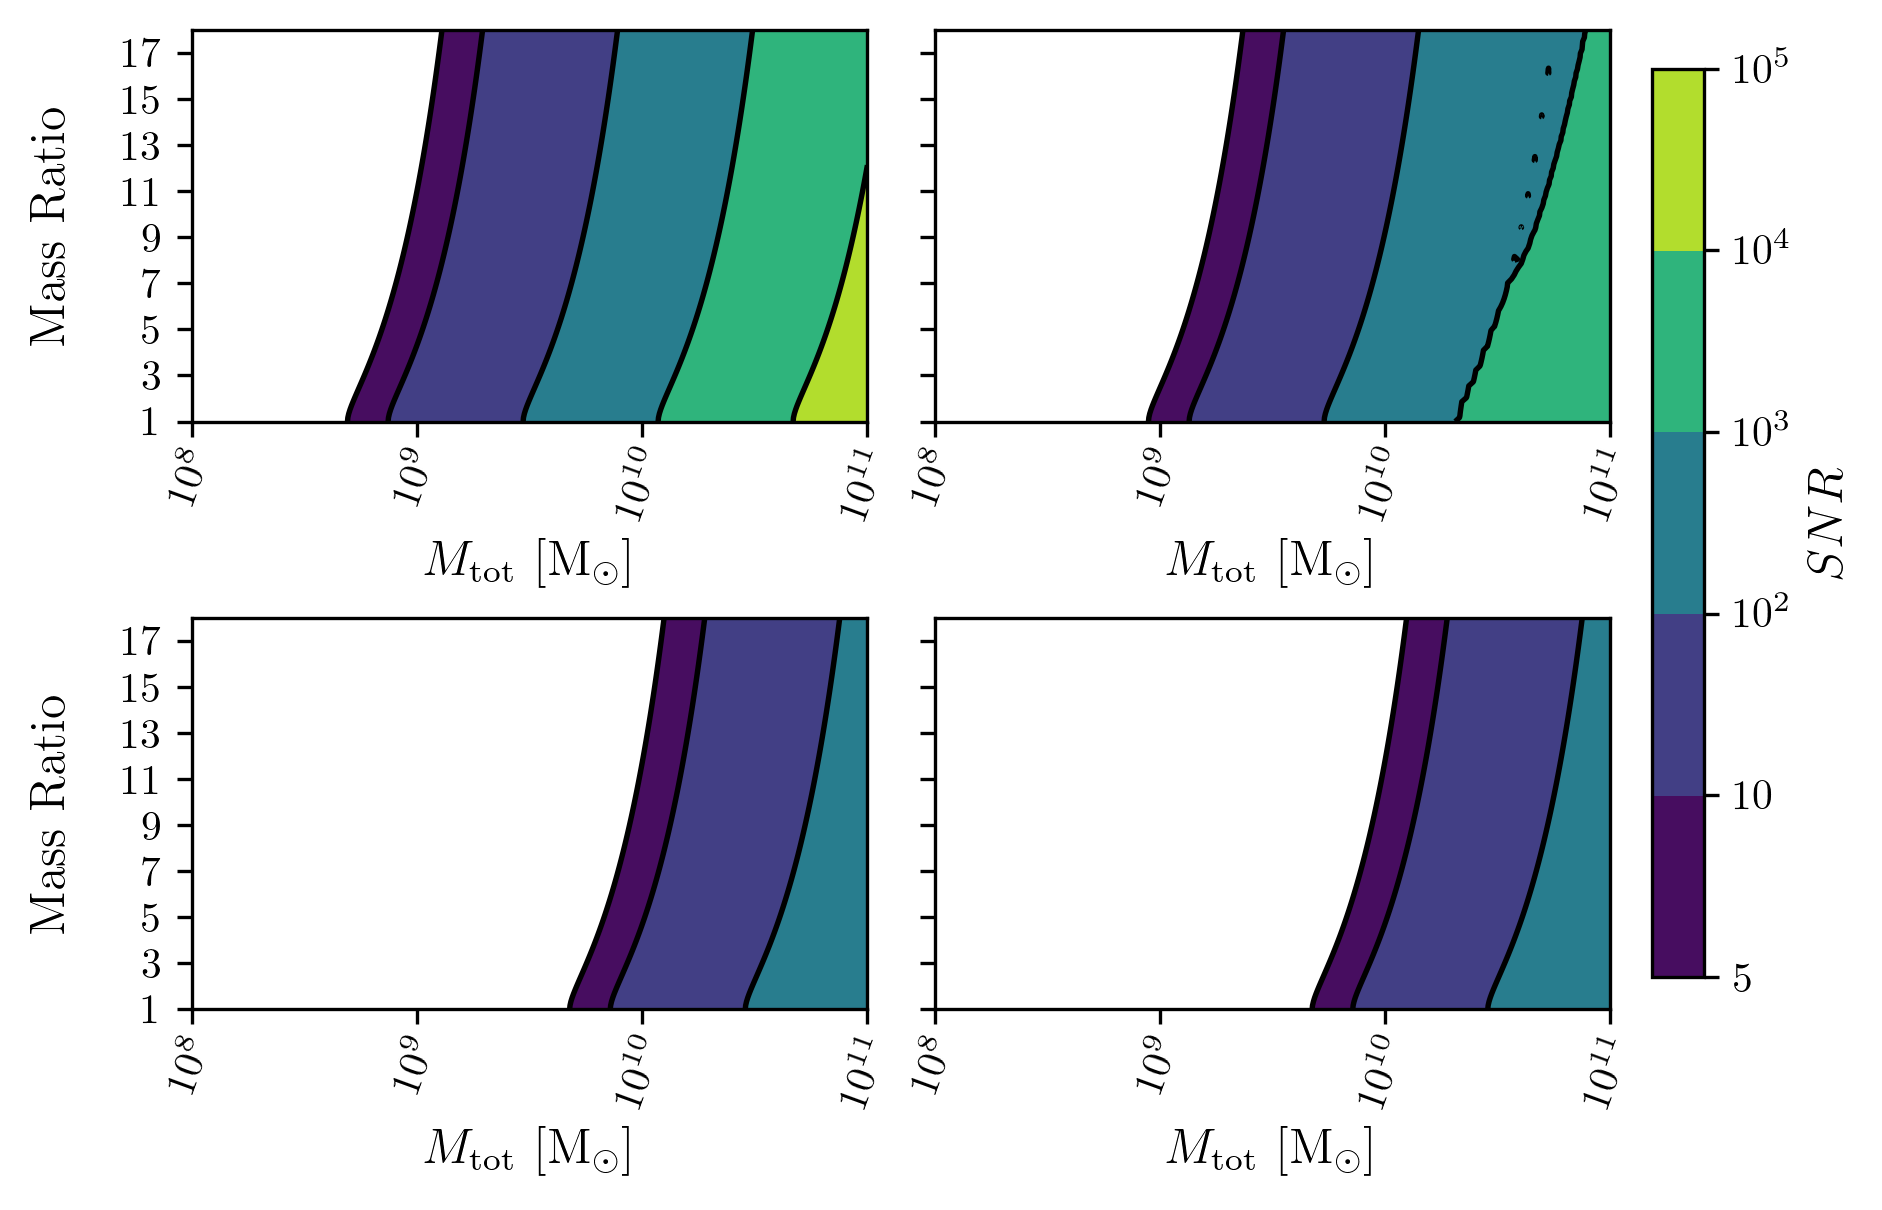

In [141]:
#########################
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [SKA_WN_Samples_M_vs_q,SKA_WN_GWB_Samples_M_vs_q,
           SKA_realistic_noise_Samples_M_vs_q,SKA_realistic_noise_Samples_M_vs_q]
SNRs = [SKA_WN_SNR_M_vs_q,SKA_WN_GWB_SNR_M_vs_q,
        SKA_realistic_noise_SNR_M_vs_q,SKA_realistic_noise_SNR_M_vs_q]
loglevelMax=5.0
hspace = .5
wspace = .1
y_label_loc = -.175

ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'q',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        ii += 1

M vs. z

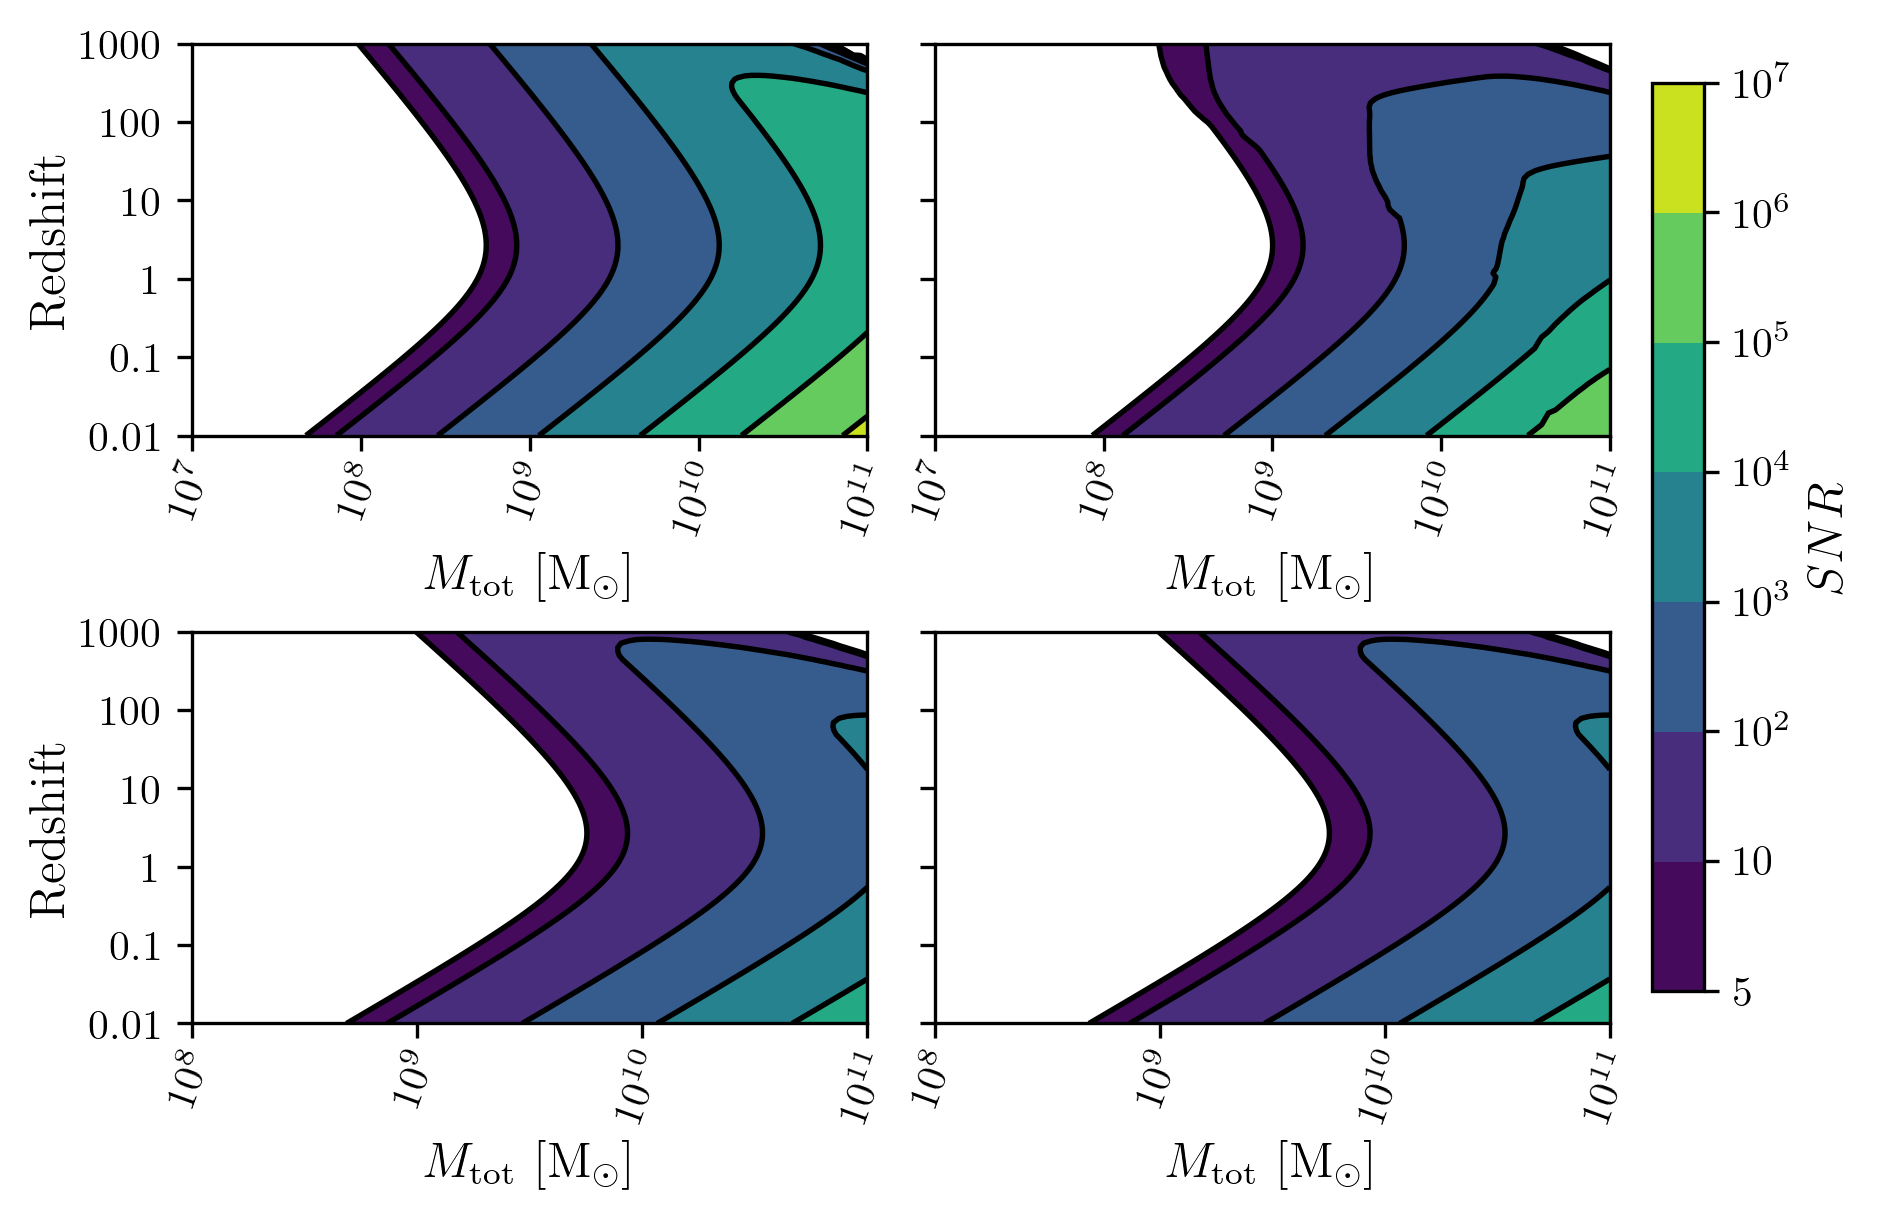

In [142]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [SKA_WN_Samples_M_vs_z,SKA_WN_GWB_Samples_M_vs_z,
           SKA_realistic_noise_Samples_M_vs_z,SKA_realistic_noise_Samples_M_vs_z]
SNRs = [SKA_WN_SNR_M_vs_z,SKA_WN_GWB_SNR_M_vs_z,
        SKA_realistic_noise_SNR_M_vs_z,SKA_realistic_noise_SNR_M_vs_z]
loglevelMax=7.0
wspace = .1
hspace = .5
y_label_loc = -.175

ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'z',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        ii += 1
#fig.savefig(save_directory+'SNR_SKA_model_comp_M_vs_z.pdf',bbox_inches='tight')

M vs. chi1

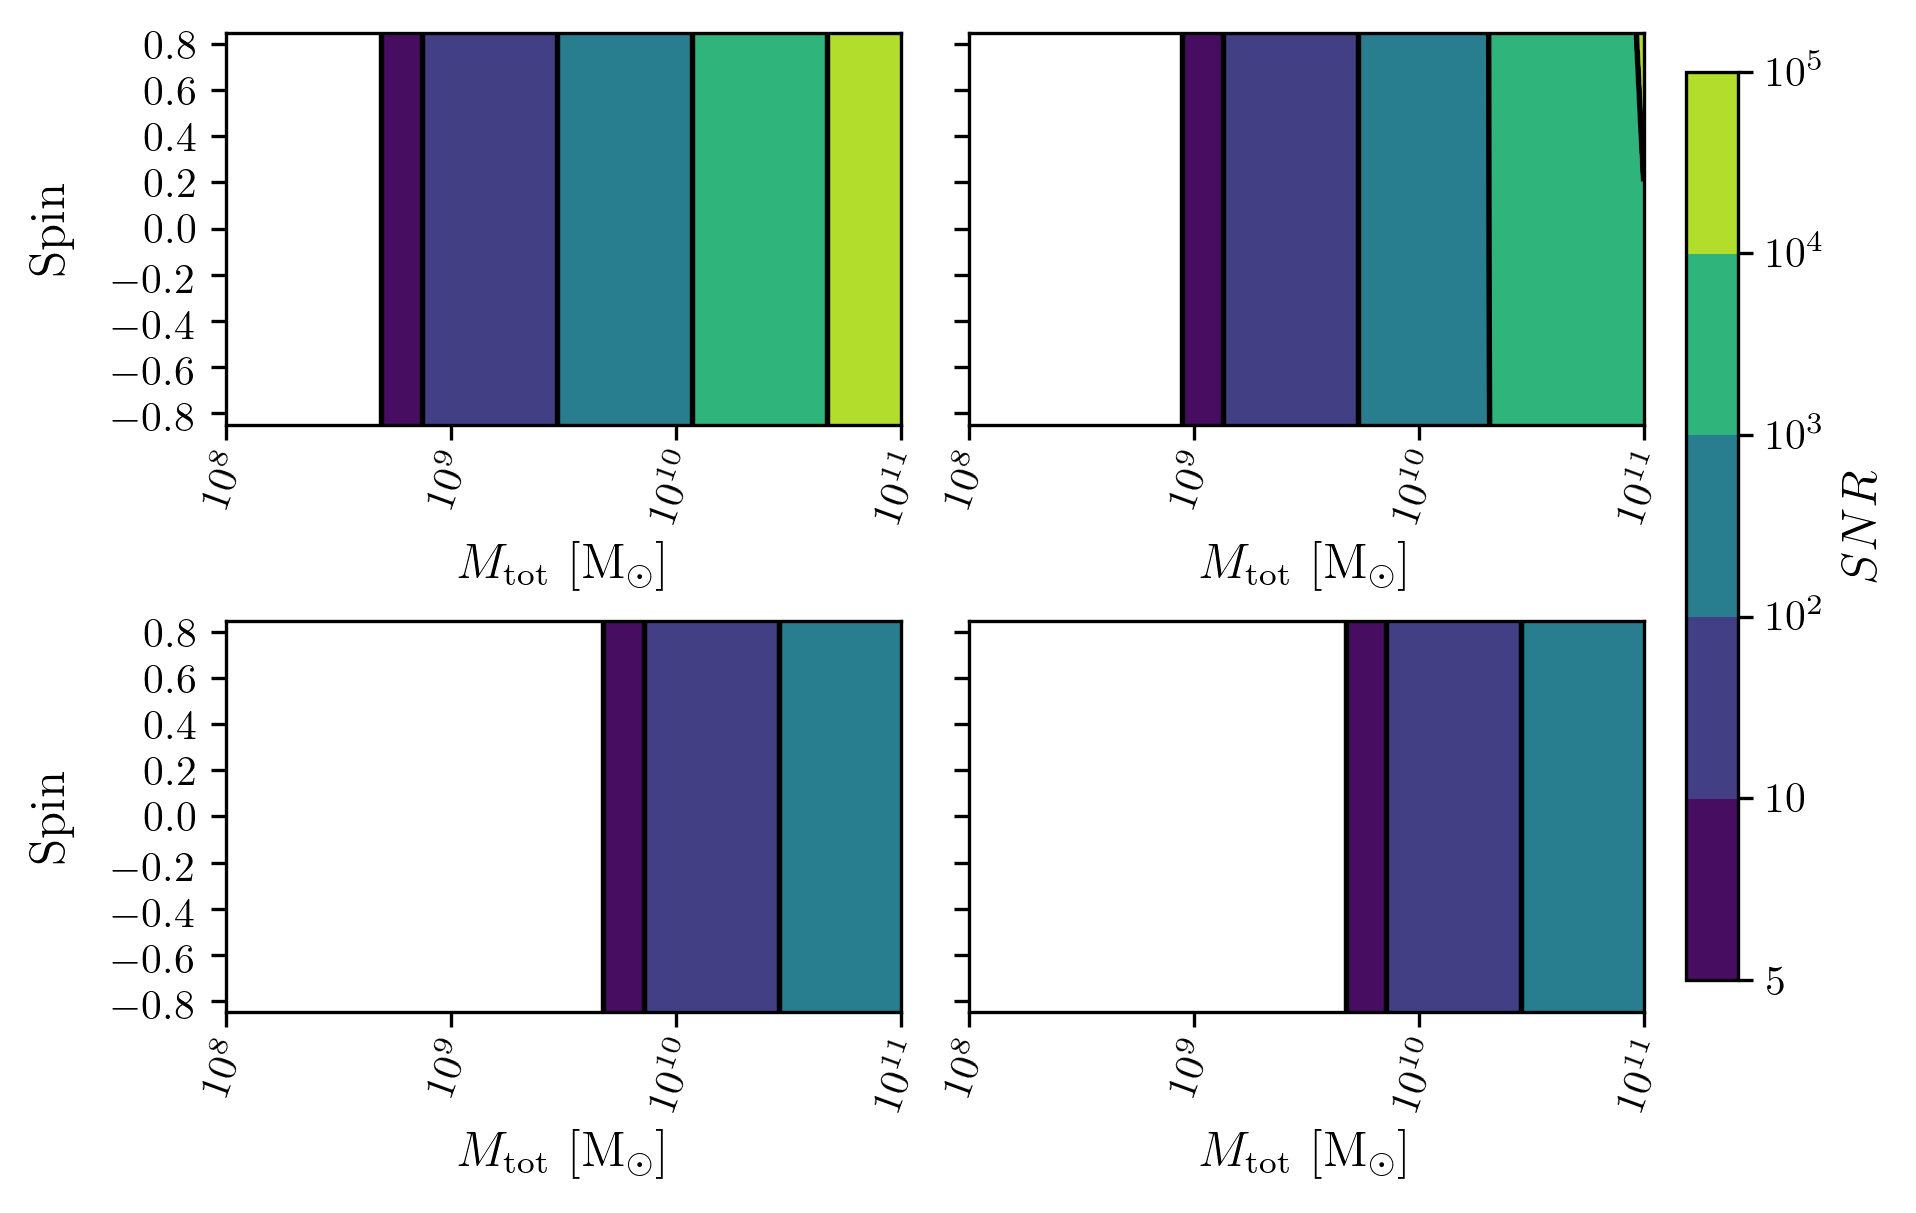

In [143]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [SKA_WN_Samples_M_vs_chi1,SKA_WN_GWB_Samples_M_vs_chi1,
           SKA_realistic_noise_Samples_M_vs_chi1,SKA_realistic_noise_Samples_M_vs_chi1]
SNRs = [SKA_WN_SNR_M_vs_chi1,SKA_WN_GWB_SNR_M_vs_chi1,
        SKA_realistic_noise_SNR_M_vs_chi1,SKA_realistic_noise_SNR_M_vs_chi1]
loglevelMax=5.0
wspace = .1
hspace = .5
y_label_loc = -.175

ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'chi1',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        ii += 1

M vs. N_p

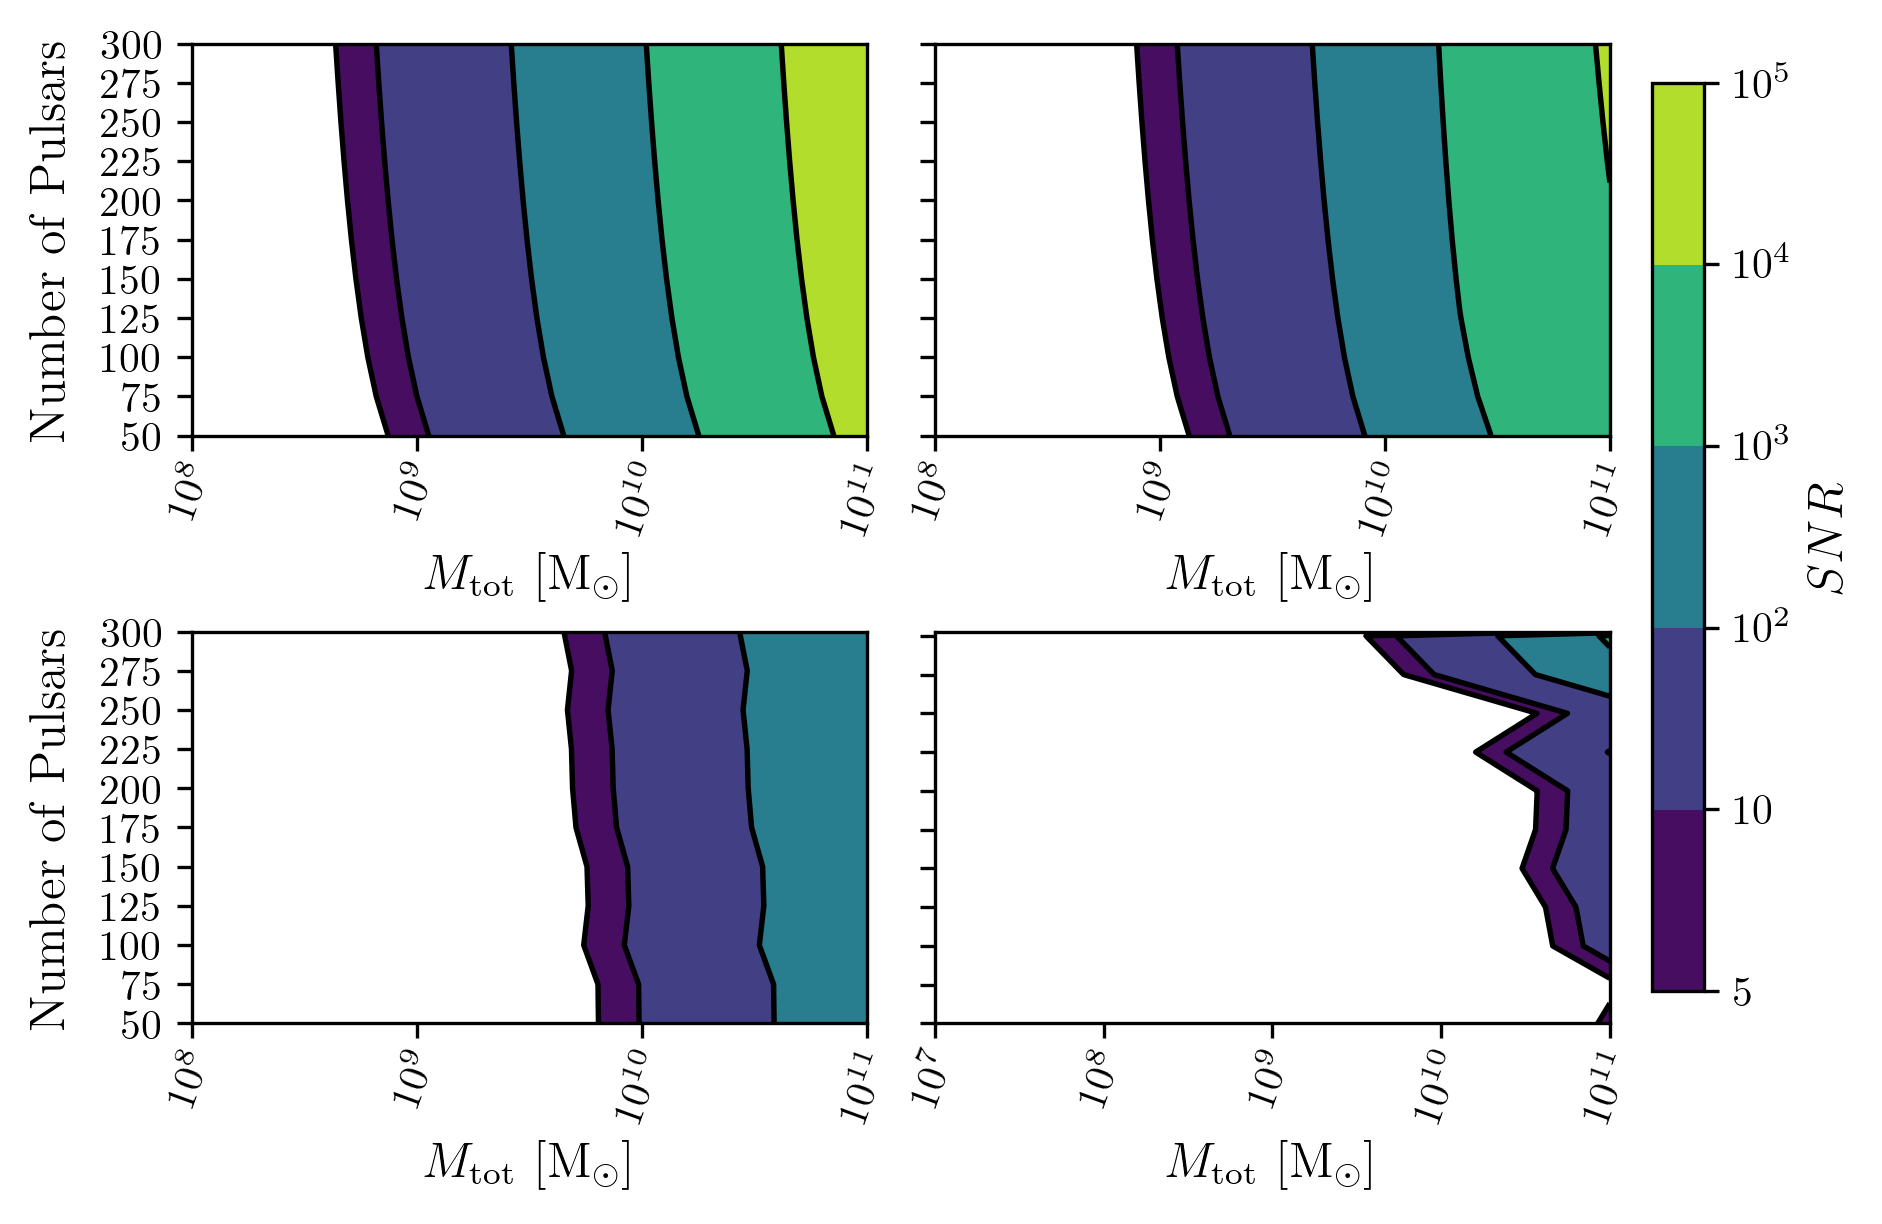

In [144]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples_x = [SKA_WN_Samples_M_vs_N_p_x,SKA_WN_GWB_Samples_M_vs_N_p_x,
             SKA_realistic_noise_Samples_M_vs_N_p_x,SKA_WN_RN_Samples_M_vs_N_p_x]
samples_y = [SKA_WN_Samples_M_vs_N_p_y,SKA_WN_GWB_Samples_M_vs_N_p_y,
             SKA_realistic_noise_Samples_M_vs_N_p_y,SKA_WN_RN_Samples_M_vs_N_p_y]
SNRs = [SKA_WN_SNR_M_vs_N_p,SKA_WN_GWB_SNR_M_vs_N_p,
        SKA_realistic_noise_SNR_M_vs_N_p,SKA_WN_RN_SNR_M_vs_N_p]
loglevelMax=5.0
wspace = .1
hspcae = .5
y_label_loc = -.175
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,wspace=wspace,hspace=hspace,)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples_x[ii],'N_p',samples_y[ii],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        ii += 1

M vs. cadence

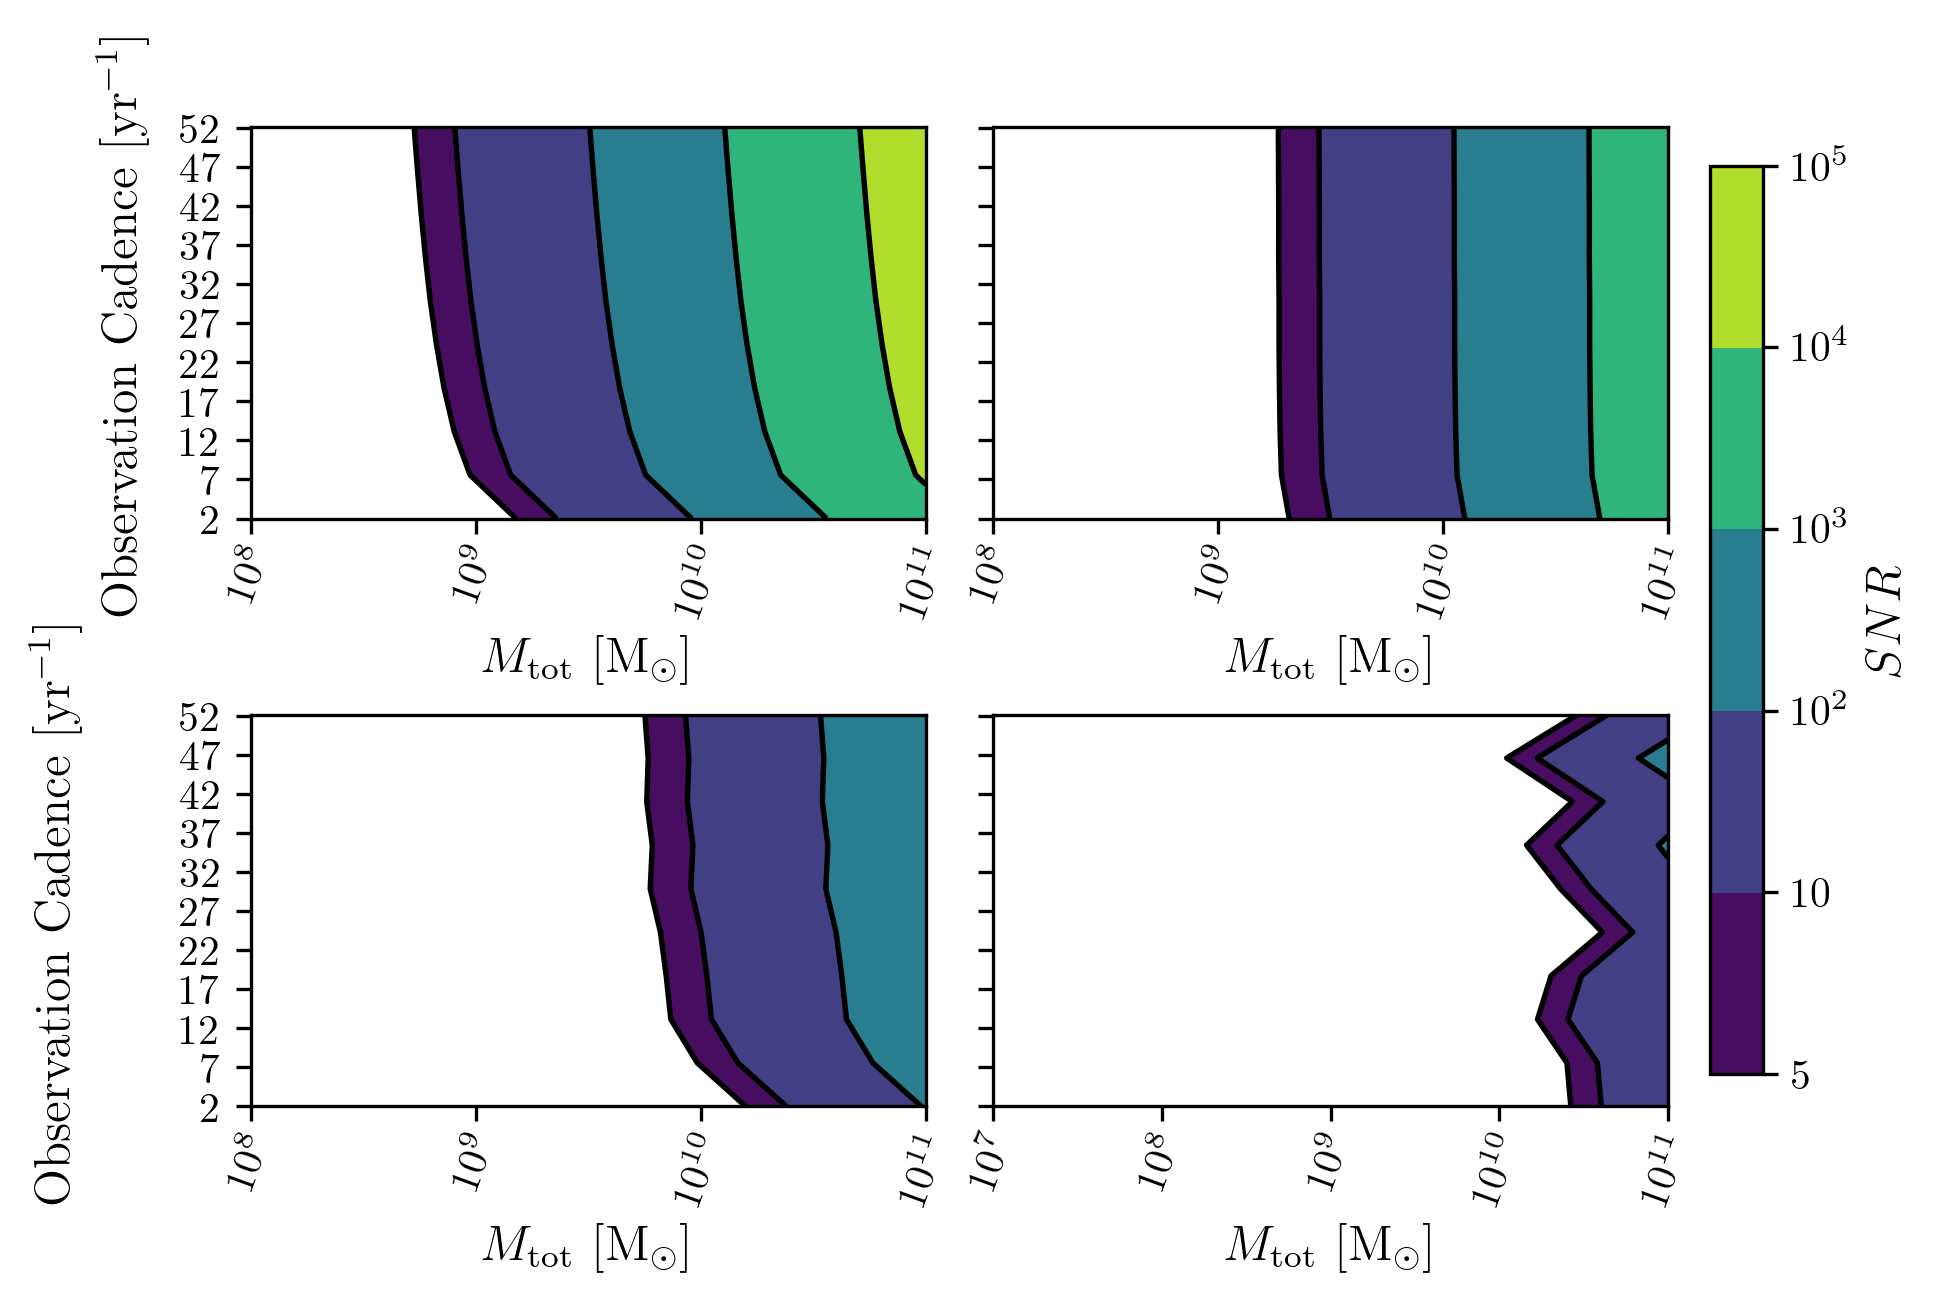

In [145]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [SKA_WN_Samples_M_vs_cadence,SKA_WN_GWB_Samples_M_vs_cadence,
           SKA_realistic_noise_Samples_M_vs_cadence,SKA_WN_RN_Samples_M_vs_cadence]
SNRs = [SKA_WN_SNR_M_vs_cadence,SKA_WN_GWB_SNR_M_vs_cadence,
        SKA_realistic_noise_SNR_M_vs_cadence,SKA_WN_RN_SNR_M_vs_cadence]
loglevelMax=5.0
wspace = .1
hspace = .5
y_label_loc = -.15
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,
                     wspace=wspace,hspace=hspace,logLevels_max=loglevelMax)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,wspace=wspace,hspace=hspace,)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'cadence',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc-.1)
        ii += 1

M vs. T_obs

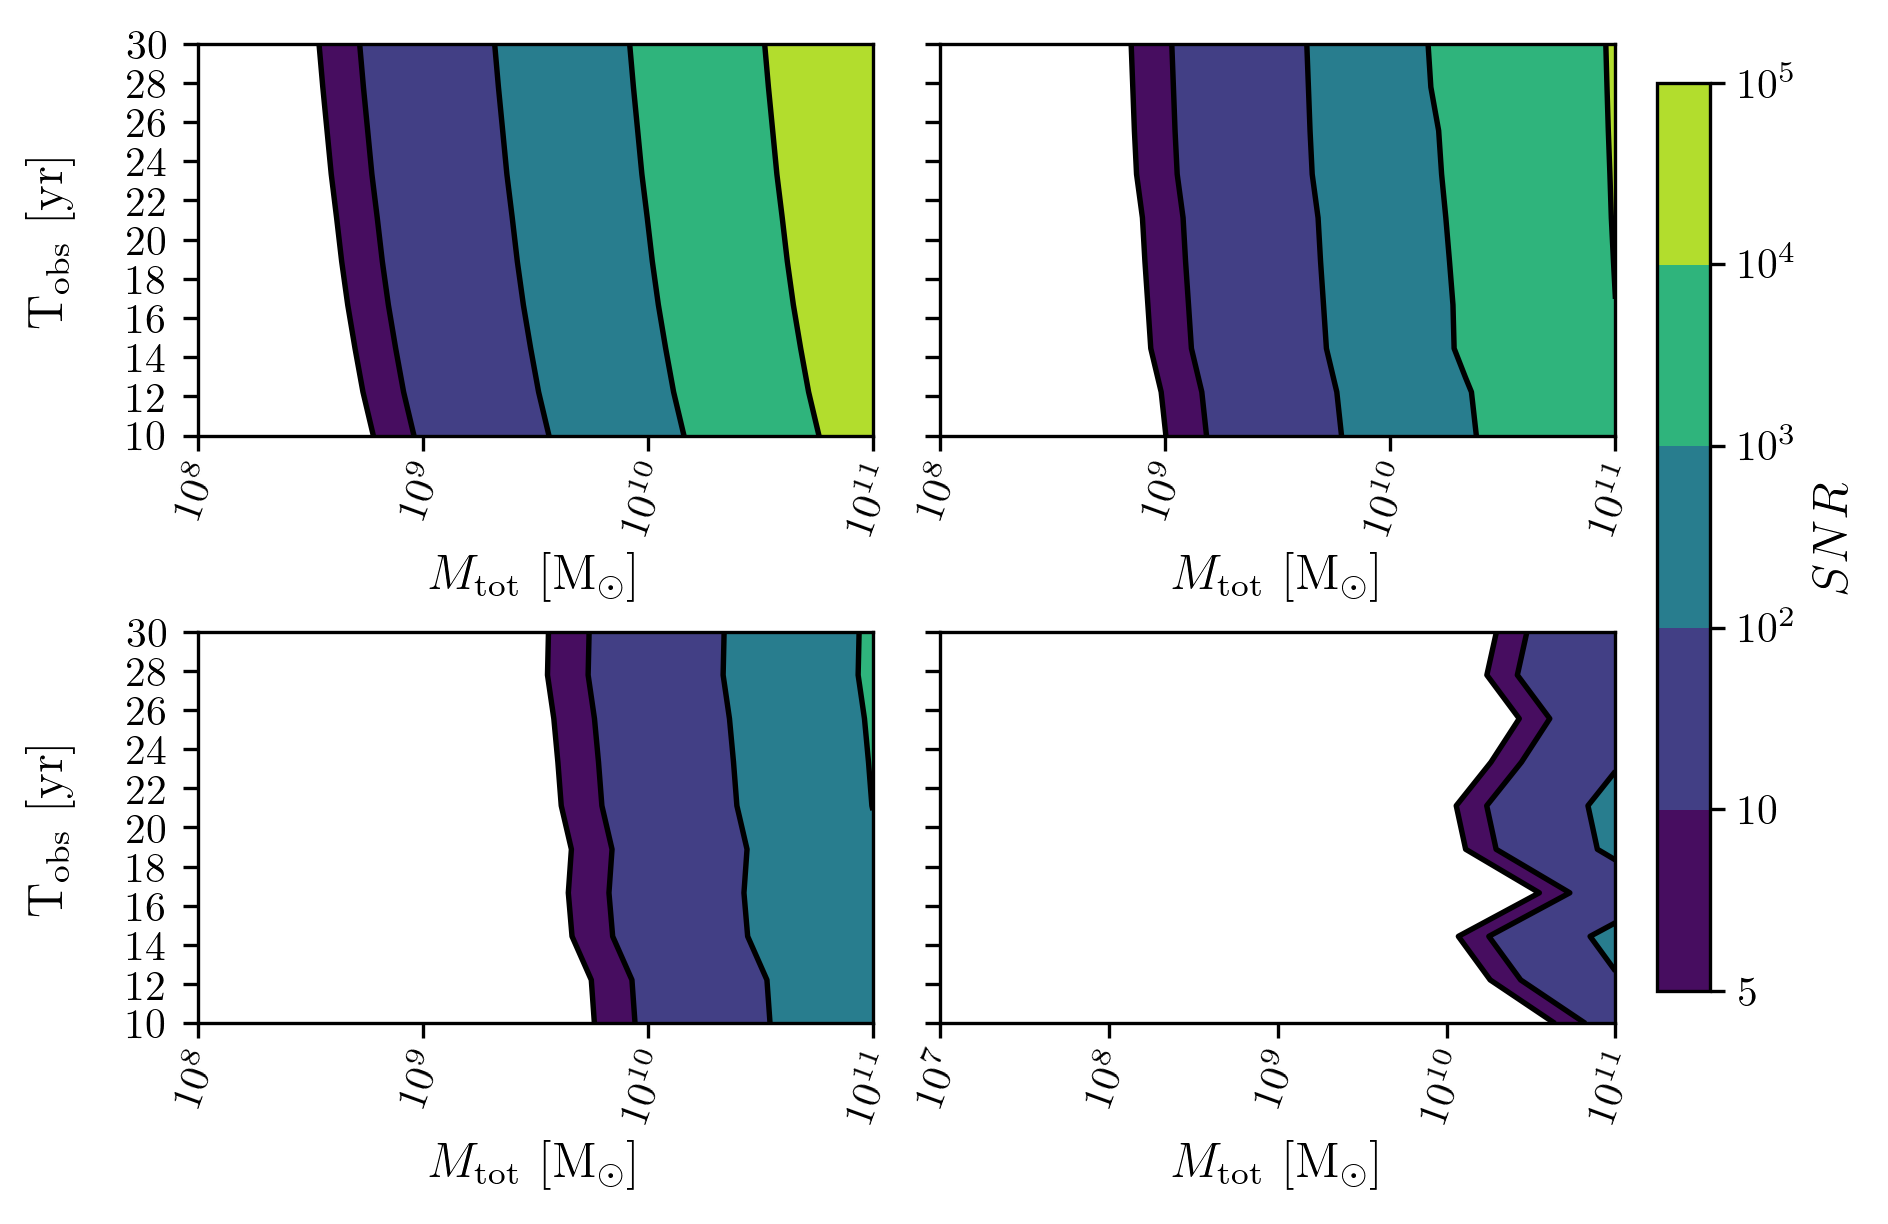

In [147]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [SKA_WN_Samples_M_vs_T_obs,SKA_WN_GWB_Samples_M_vs_T_obs,
           SKA_realistic_noise_Samples_M_vs_T_obs,SKA_WN_RN_Samples_M_vs_T_obs]
SNRs = [SKA_WN_SNR_M_vs_T_obs,SKA_WN_GWB_SNR_M_vs_T_obs,
        SKA_realistic_noise_SNR_M_vs_T_obs,SKA_WN_RN_SNR_M_vs_T_obs]
loglevelMax=5.0
wspace = .1
hspace = .5
y_label_loc = -.175
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,wspace=wspace,hspace=hspace)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'T_obs',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        ii += 1

M vs. sigma

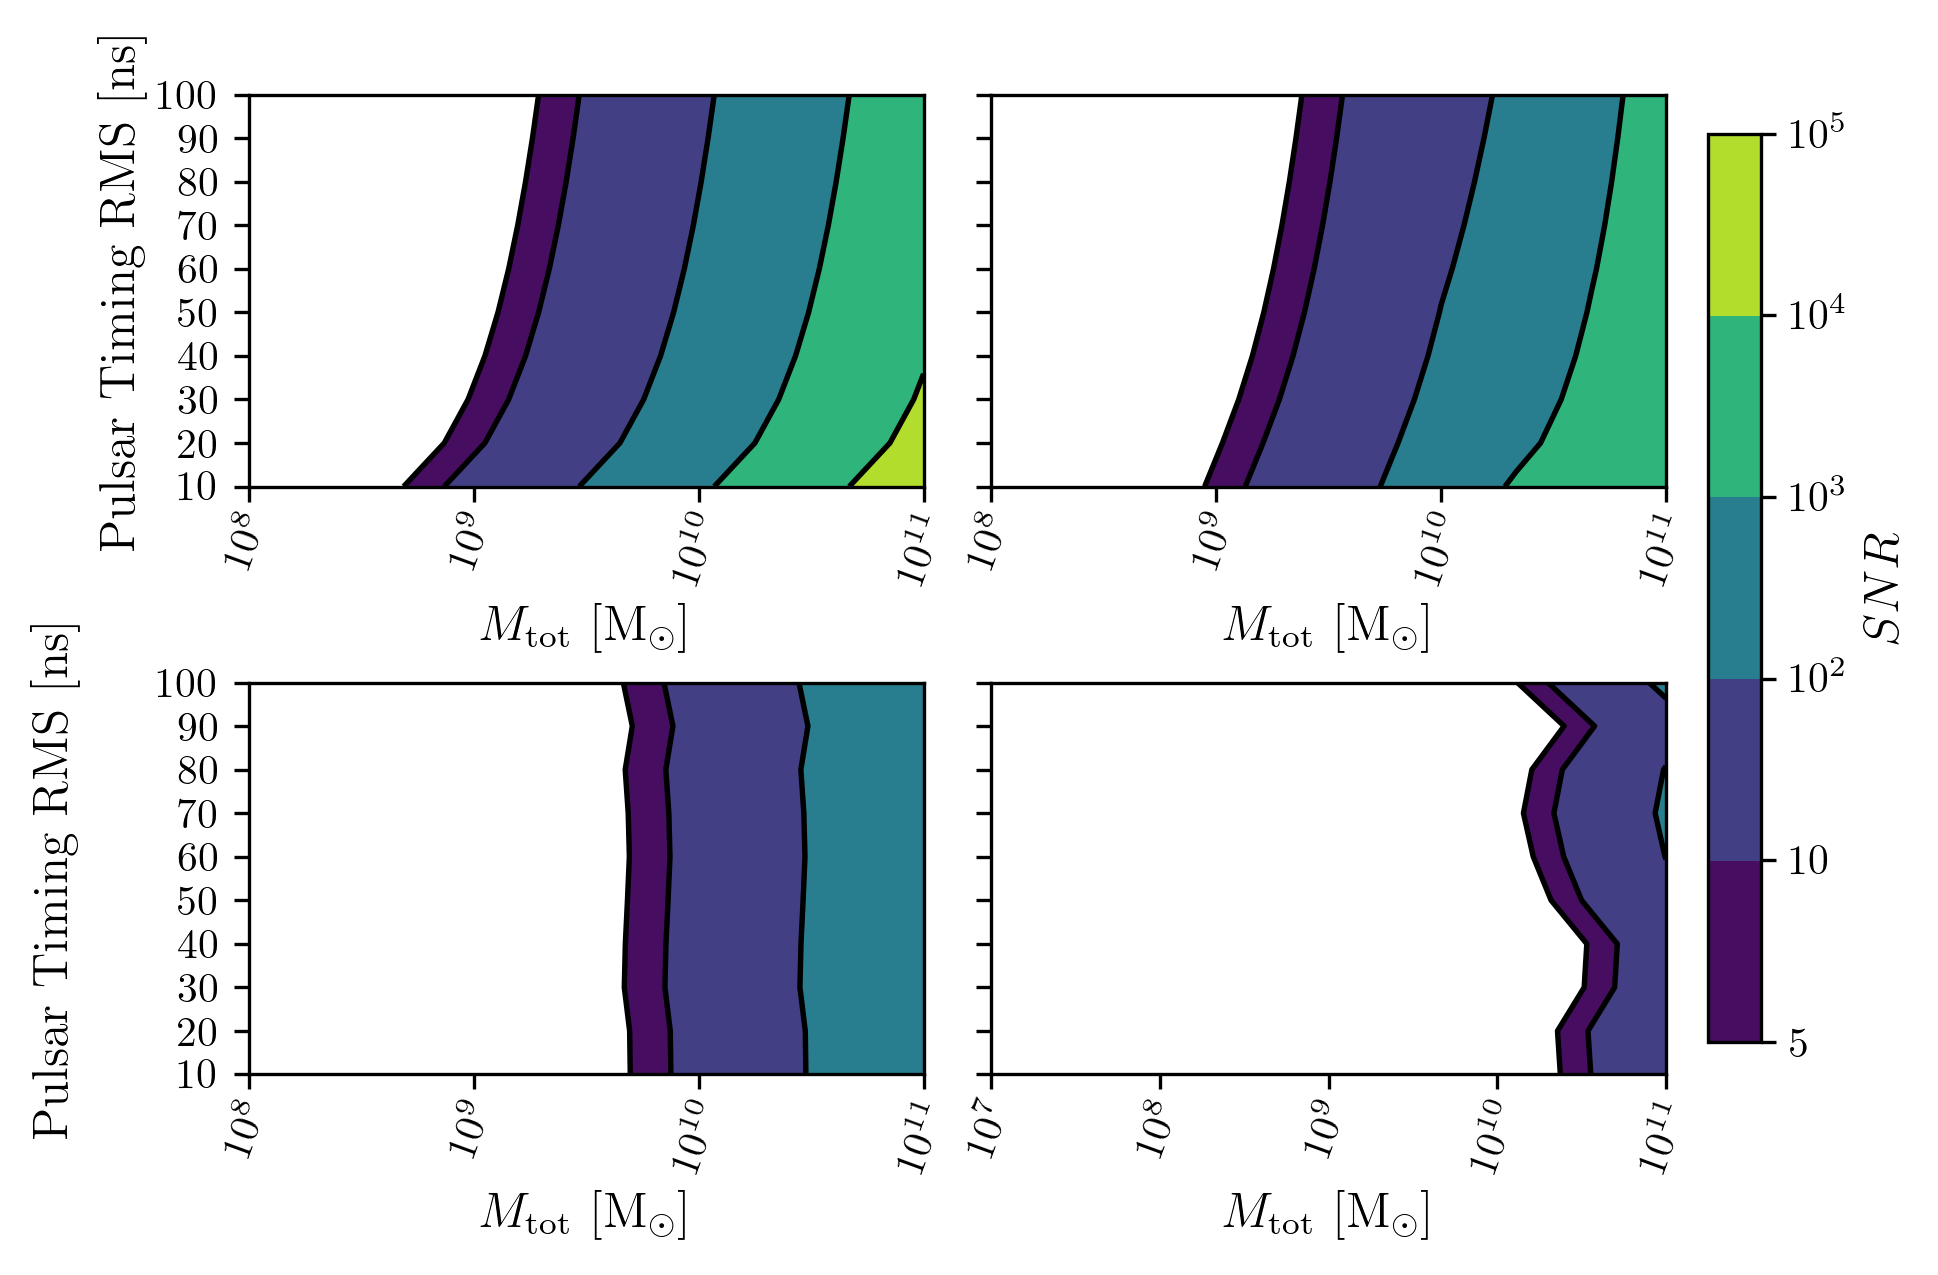

In [148]:
#Make the Contour Plots
figsize = get_fig_size(scale=1.0)
fig, axes = plt.subplots(2,2,figsize=figsize)
samples = [SKA_WN_Samples_M_vs_sigma,SKA_WN_GWB_Samples_M_vs_sigma,
           SKA_realistic_noise_Samples_M_vs_sigma,SKA_WN_RN_Samples_M_vs_sigma]
SNRs = [SKA_WN_SNR_M_vs_sigma,SKA_WN_GWB_SNR_M_vs_sigma,
        SKA_realistic_noise_SNR_M_vs_sigma,SKA_WN_RN_SNR_M_vs_sigma]
loglevelMax=5.0
wspace = .1
hspace = .5
y_label_loc = -.15
ii = 0
for i in range(2):
    for j in range(2):
        if ii == 0:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=True,x_axis_label=True,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc)
        elif ii == 1:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,x_axis_label=True,
                     y_axis_label=False,logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace)
        elif ii == 3:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                 SNRs[ii],display=True,display_cbar=False,y_axis_label=False,
                     logLevels_max=loglevelMax,wspace=wspace,hspace=hspace)
        else:
            Plot_SNR(fig,axes[i,j],'M',samples[ii][:,0],'sigma',samples[ii][:,1],
                     SNRs[ii],display=False,display_cbar=False,
                     logLevels_max=loglevelMax,
                     wspace=wspace,hspace=hspace,y_label_loc=y_label_loc-.1)
        ii += 1

## Make Waterfall Plots

Sets plotting parameters

In [132]:
contourcolorPresent = 'plasma'
transparencyPresent = 1.0
contourcolorFuture = 'plasma'
transparencyFuture = 0.6
textsize = 10
textcolor1 = 'k'
textcolor2 = 'w'

Selects contour levels to separate sections into

In [133]:
contLevels = np.array([5, 10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
logLevels = np.log10(contLevels)

Set labels for x and y axes

In [134]:
Mlabel_min = 0
Mlabel_max = 11
zlabel_min = -2.0
zlabel_max = 3.0
zlabels = np.logspace(zlabel_min,zlabel_max,zlabel_max-zlabel_min+1)
Mlabels = np.logspace(Mlabel_min,Mlabel_max,Mlabel_max-Mlabel_min+1)

Set labels for lookback time on y-axis

In [135]:
ages1 = np.array([13.5,13,10,5,1])*u.Gyr 
ages2 = np.array([500,100,10,1])*u.Myr
ages2 = ages2.to('Gyr')
ages = np.hstack((ages1.value,ages2.value))
ages = ages*u.Gyr
ageticks = [z_at_value(cosmo.age,age) for age in ages]

Add Label positions and labels for different GW detectors

In [136]:
labelaLIGO_text = 'aLIGO\n(2016)'
labelaLIGO_xpos = 0.22
labelaLIGO_ypos = 0.125

labelnanograv_text = 'NANOGrav\n(2018)'
labelnanograv_xpos = 0.925
labelnanograv_ypos = 0.175

labelet_text = 'ET\n($\sim$2030s)'
labelet_xpos = 0.175
labelet_ypos = 0.6

labelLisa_text = 'LISA\n($\sim$2030s)'
labelLisa_xpos = 0.615
labelLisa_ypos = 0.1

labelIpta_text = 'IPTA\n($\sim$2030s)'
labelIpta_xpos = 0.9
labelIpta_ypos = 0.93

#### Plots of Entire GW Band

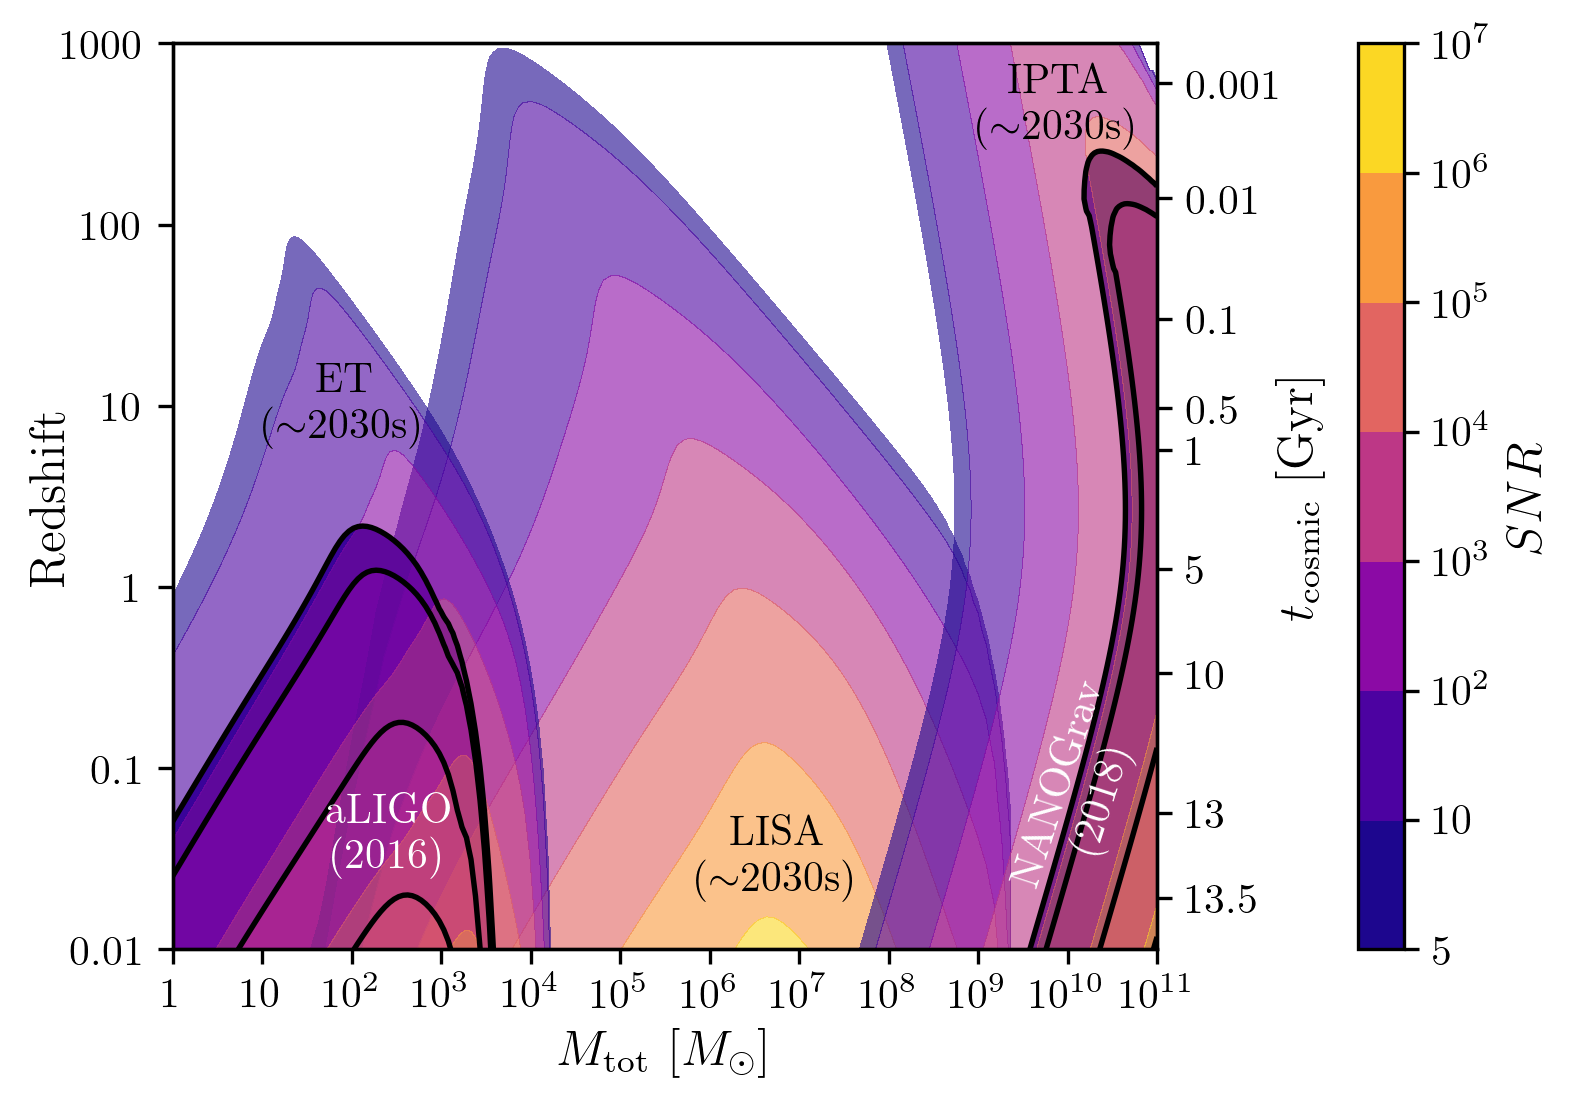

In [149]:
fig, ax1 = plt.subplots()

#Set other side y-axis for lookback time scalings
ax2 = ax1.twinx()

CS1 = ax1.contourf(np.log10(NANOGrav_11yr_Samples_M_vs_z[:,0]),np.log10(NANOGrav_11yr_Samples_M_vs_z[:,1]),
                   np.log10(NANOGrav_11yr_SNR_M_vs_z),logLevels,cmap = contourcolorPresent, alpha = transparencyPresent)

ax2.contour(np.log10(NANOGrav_11yr_Samples_M_vs_z[:,0]),np.log10(NANOGrav_11yr_Samples_M_vs_z[:,1]),
            np.log10(NANOGrav_11yr_SNR_M_vs_z),logLevels,colors = 'k')

ax1.contourf(np.log10(aLIGO_Samples_M_vs_z[:,0]),np.log10(aLIGO_Samples_M_vs_z[:,1]),
             np.log10(aLIGO_SNR_M_vs_z),logLevels,cmap = contourcolorPresent, alpha = transparencyPresent)

ax1.contour(np.log10(aLIGO_Samples_M_vs_z[:,0]),np.log10(aLIGO_Samples_M_vs_z[:,1]),
            np.log10(aLIGO_SNR_M_vs_z),logLevels,colors = 'k')

ax1.contourf(np.log10(lisa_Samples_M_vs_z[:,0]),np.log10(lisa_Samples_M_vs_z[:,1]),
             np.log10(lisa_SNR_M_vs_z),logLevels,cmap=contourcolorFuture, alpha = transparencyFuture)

ax1.contourf(np.log10(et_Samples_M_vs_z[:,0]),np.log10(et_Samples_M_vs_z[:,1]),
             np.log10(et_SNR_M_vs_z),logLevels,cmap = contourcolorFuture, alpha = transparencyFuture)

ax1.contourf(np.log10(SKA_WN_Samples_M_vs_z[:,0]),np.log10(SKA_WN_Samples_M_vs_z[:,1]),
             np.log10(SKA_WN_SNR_M_vs_z),logLevels,cmap = contourcolorFuture, alpha = transparencyFuture)
"""
ax1.contourf(np.log10(SKA_realistic_noise_Samples_M_vs_z[:,0]),np.log10(SKA_realistic_noise_Samples_M_vs_z[:,1]),
             np.log10(SKA_realistic_noise_SNR_M_vs_z),logLevels,cmap = contourcolorFuture, alpha = transparencyFuture)
"""
#Set axes limits 
ax1.set_xlim(np.log10(et_Samples_M_vs_z[0,0]),11)
ax1.set_ylim(np.log10(SKA_WN_Samples_M_vs_z[0,1]),np.log10(SKA_WN_Samples_M_vs_z[-1,1]))


#Set ticks and labels
ax1.set_yticks(np.log10(zlabels))
ax1.set_xticks(np.log10(Mlabels))
ax1.set_xticklabels([r'$10^{%i}$' %y if int(y) > 1 else r'$%i$' %(10**y) for y in np.log10(Mlabels)])
ax1.set_yticklabels([x if int(x) < 1 else int(x) for x in zlabels])

ax1.set_xlabel(r'$M_{\rm tot}$ $[M_{\odot}]$')
ax1.set_ylabel(r'${\rm Redshift}$')
ax1.yaxis.set_label_coords(-.1,.5)

ax2.set_yticks(np.log10(ageticks))
ax2.set_yticklabels(['{:g}'.format(age) for age in ages.value])
ax2.set_ylabel(r'$t_{\rm cosmic}$ [Gyr]')
ax2.yaxis.set_label_coords(1.125,.5)

#Label different GW detectors
plt.text(labelaLIGO_xpos,labelaLIGO_ypos,labelaLIGO_text,fontsize = textsize, \
         horizontalalignment='center',verticalalignment='center', color = textcolor2,transform = ax1.transAxes)

plt.text(labelnanograv_xpos,labelnanograv_ypos,labelnanograv_text,fontsize = textsize,\
         horizontalalignment='center',verticalalignment='center', color = textcolor2,transform = ax1.transAxes,\
        rotation=72)

plt.text(labelet_xpos,labelet_ypos,labelet_text,fontsize = textsize,\
         horizontalalignment='center',verticalalignment='center', color = textcolor1,transform = ax1.transAxes)

plt.text(labelLisa_xpos,labelLisa_ypos,labelLisa_text,fontsize = textsize,\
         horizontalalignment='center',verticalalignment='center', color = textcolor1,transform = ax1.transAxes)

plt.text(labelIpta_xpos,labelIpta_ypos,labelIpta_text,fontsize = textsize,\
         horizontalalignment='center',verticalalignment='center', color = textcolor1,transform = ax1.transAxes)

#Make colorbar
cbar = fig.colorbar(CS1,ax=(ax1,ax2),pad=0.01)
cbar.set_label(r'$SNR$')
cbar.ax.set_yticklabels([r'$10^{%i}$' %x if int(x) > 1 else r'$%i$' %(10**x) for x in logLevels])
#fig.savefig(save_directory+'full_waterfall_plots_lb.pdf',bbox_inches='tight')
plt.show()